# CP1: 기대 수명 예측하기

## 1. 데이터 불러오기

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats.mstats import winsorize
from scipy.stats import chi2_contingency
from sklearn.metrics import  mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV, ElasticNet, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

In [3]:
# 데이터 불러오기
df = pd.read_csv('/Users/minky/Library/Mobile Documents/com~apple~CloudDocs/AIB/프로젝트/CP1/life_ex.csv')
df.head(3)

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9


In [4]:
# 데이터 평균/중앙/최소/최대 등 값 확인
df.describe().iloc[:, 1:]

,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
count,2928.000000,2928.000000,2938.000000,2744.000000,2938.000000,2385.000000,2938.000000,2904.000000,2938.000000,2919.000000,2712.00000,2919.000000,2938.000000,2490.000000,2.286000e+03,2904.000000,2904.000000,2771.000000,2775.000000
mean,69.224932,164.796448,30.303948,4.602861,738.251295,80.940461,2419.592240,38.321247,42.035739,82.550188,5.93819,82.324084,1.742103,7483.158469,1.275338e+07,4.839704,4.870317,0.627551,11.992793
std,9.523867,124.292079,117.926501,4.052413,1987.914858,25.070016,11467.272489,20.044034,160.445548,23.428046,2.49832,23.716912,5.077785,14270.169342,6.101210e+07,4.420195,4.508882,0.210904,3.358920
min,36.300000,1.000000,0.000000,0.010000,0.000000,1.000000,0.000000,1.000000,0.000000,3.000000,0.37000,2.000000,0.100000,1.681350,3.400000e+01,0.100000,0.100000,0.000000,0.000000
25%,63.100000,74.000000,0.000000,0.877500,4.685343,77.000000,0.000000,19.300000,0.000000,78.000000,4.26000,78.000000,0.100000,463.935626,1.957932e+05,1.600000,1.500000,0.493000,10.100000
50%,72.100000,144.000000,3.000000,3.755000,64.912906,92.000000,17.000000,43.500000,4.000000,93.000000,5.75500,93.000000,0.100000,1766.947595,1.386542e+06,3.300000,3.300000,0.677000,12.300000
75%,75.700000,228.000000,22.000000,7.702500,441.534144,97.000000,360.250000,56.200000,28.000000,97.000000,7.49250,97.000000,0.800000,5910.806335,7.420359e+06,7.200000,7.200000,0.779000,14.300000
max,89.000000,723.000000,1800.000000,17.870000,19479.911610,99.000000,212183.000000,87.300000,2500.000000,99.000000,17.60000,99.000000,50.600000,119172.741800,1.293859e+09,27.700000,28.600000,0.948000,20.700000


In [5]:
# 결측치 확인& 중복 확인
print('결측치: \n',df.isna().sum())
print('---------------------------------------------')
print('중복: ', df.duplicated().sum())
print('---------------------------------------------')
print('데이터셋 크기: ', df.shape)

결측치: 
 Country                              0
Year                                 0
Status                               0
Life expectancy                     10
Adult Mortality                     10
infant deaths                        0
Alcohol                            194
percentage expenditure               0
Hepatitis B                        553
Measles                              0
BMI                                 34
under-five deaths                    0
Polio                               19
Total expenditure                  226
Diphtheria                          19
HIV/AIDS                             0
GDP                                448
Population                         652
 thinness  1-19 years               34
 thinness 5-9 years                 34
Income composition of resources    167
Schooling                          163
dtype: int64
---------------------------------------------
중복:  0
---------------------------------------------
데이터셋 크기:  (2938, 22)


## 2. 데이터 전처리
### 2-1. 컬럼명 재설정 및 단위 통일
- 먼저 컬럼명을 설명에 맞게 다시 재설정한다.
- 그리고 adult_mortality, infant_mortality, under-five_mortality, measles와 같은 컬럼을 nums가 아닌 확률로 표기하도록 통일시킨다.

In [5]:
def rename_cols(df):    # 컬럼명 재설정: 데이터 설명보고 설명에 맞게 다시 재설정함
    df.rename(columns = {' thinness  1-19 years':'thin 1019',' thinness 5-9 years':'thin 59', 'Income composition of resources':'HDI', 'infant deaths':'Infant Mortality', 'under-five deaths':'Under_five Mortality', 'HIV/AIDS':'hiv'},inplace=True)
    df = df.replace('United Kingdom of Great Britain and Northern Ireland', 'UK&Ireland')
    # 컬럼명을 소문자로 통일시키고 공백을 _로 대체
    new_cols = []
    for col in list(df.columns):
        new_cols.append(col.strip().replace(' ', '_').lower())
    df.columns = new_cols


    return df

def nums_to_rate(x):  # 1000명당 해당 nums를 확률로 표기 통일하기
    x = x/1000
    return x

In [6]:
# rename_cols 함수 적용해 data cleaning
df = rename_cols(df)

## rename_cols가 잘 적용되었는지 확인하기
print(df.columns)
print('-'*30)
print(df['country'].unique())

Index(['country', 'year', 'status', 'life_expectancy', 'adult_mortality',
       'infant_mortality', 'alcohol', 'percentage_expenditure', 'hepatitis_b',
       'measles', 'bmi', 'under_five_mortality', 'polio', 'total_expenditure',
       'diphtheria', 'hiv', 'gdp', 'population', 'thin_1019', 'thin_59', 'hdi',
       'schooling'],
      dtype='object')
------------------------------
['Afghanistan' 'Albania' 'Algeria' 'Angola' 'Antigua and Barbuda'
 'Argentina' 'Armenia' 'Australia' 'Austria' 'Azerbaijan' 'Bahamas'
 'Bahrain' 'Bangladesh' 'Barbados' 'Belarus' 'Belgium' 'Belize' 'Benin'
 'Bhutan' 'Bolivia (Plurinational State of)' 'Bosnia and Herzegovina'
 'Botswana' 'Brazil' 'Brunei Darussalam' 'Bulgaria' 'Burkina Faso'
 'Burundi' "Côte d'Ivoire" 'Cabo Verde' 'Cambodia' 'Cameroon' 'Canada'
 'Central African Republic' 'Chad' 'Chile' 'China' 'Colombia' 'Comoros'
 'Congo' 'Cook Islands' 'Costa Rica' 'Croatia' 'Cuba' 'Cyprus' 'Czechia'
 "Democratic People's Republic of Korea"
 'Democratic R

In [7]:
# nums_to_rate 함수 적용해 nums -> 확률로 변환하기
lista = ['adult_mortality', 'infant_mortality', 'under_five_mortality', 'measles']
for i in lista:
    df[i] = nums_to_rate(df[i])

# nums_to_rate 함수 잘 적용되었는지 확인
df[['adult_mortality', 'infant_mortality', 'under_five_mortality', 'measles']].head()

,adult_mortality,infant_mortality,under_five_mortality,measles
0,0.263,0.062,0.083,1.154
1,0.271,0.064,0.086,0.492
2,0.268,0.066,0.089,0.430
3,0.272,0.069,0.093,2.787
4,0.275,0.071,0.097,3.013


### 2-2. 결측치 처리

    방법 1) 각 국가별로 결측치를 보간하여 처리하기

    방법 2) 시계열 데이터이기 때문에 각 년도별로 결측치를 보간하여 처리하기

    방법 3) 제거하여 결측치 처리

In [8]:
# 방법 1) 각 국가별로 보간 진행
cols_list = list(df.columns)[3:]

df1 = df.copy()

for country in list(df['country'].unique()):
    df1.loc[df1['country'] == country, cols_list] = df1.loc[df1['country'] == country, cols_list].interpolate()
    
# 보간 이후 남아있는 결측치는 제거하여 처리
df1.dropna(inplace=True)

In [ ]:
# 결측치 처리 후 데이터 summary
print(df1.shape)              # 데이터 크기: (1987, 22)
print('-------------------------------------------')
print(df1.describe())

(1987, 22)
-------------------------------------------
              year  life_expectancy  adult_mortality  infant_mortality  \
count  1987.000000      1987.000000      1987.000000       1987.000000   
mean   2006.984902        67.981782         0.175187          0.036624   
std       4.323147         9.706401         0.131617          0.138785   
min    2000.000000        36.300000         0.001000          0.000000   
25%    2003.000000        61.700000         0.075000          0.001000   
50%    2007.000000        69.900000         0.153000          0.004000   
75%    2011.000000        74.700000         0.243000          0.025000   
max    2015.000000        89.000000         0.723000          1.800000   

           alcohol  percentage_expenditure  hepatitis_b      measles  \
count  1987.000000             1987.000000   1987.00000  1987.000000   
mean      4.455644              685.492318     73.86160     2.729562   
std       3.976733             1761.669050     29.02807    12.

In [ ]:
# 결측치 개수 확인하기
print(df1.isna().sum())

country                   0
year                      0
status                    0
life_expectancy           0
adult_mortality           0
infant_mortality          0
alcohol                   0
percentage_expenditure    0
hepatitis_b               0
measles                   0
bmi                       0
under_five_mortality      0
polio                     0
total_expenditure         0
diphtheria                0
hiv                       0
gdp                       0
population                0
thin_1019                 0
thin_59                   0
hdi                       0
schooling                 0
dtype: int64


In [9]:
# 방법 2) 각 년도별로 보간 진행하기
df2 = df.copy()

fillna_data = []
for y in list(df2['year'].unique()):          # 각 년도별로 데이터 묶기wins_df['year'].unique()
    y_data = df2[df2['year'] == y].copy()
    for col_n in list(y_data.columns)[3:]:    # 각 년도별로 결측치를 제외하고 구한 평균값으로 결측치를 처리함
        y_data[col_n] = y_data[col_n].fillna(y_data[col_n].dropna().mean()).copy()
    fillna_data.append(y_data)

df2 = pd.concat(fillna_data).copy()           # fillna_data는 리스트이고, 이 안에 있는 데이터들을 concat해서 다시 df 형태로 변환함

In [10]:
# 결측치 처리 후 데이터 summary
print(df2.shape)              # 데이터 크기: (2938, 22)
print('-------------------------------------------')
print(df2.describe()) 

(2938, 22)
-------------------------------------------
              year  life_expectancy  adult_mortality  infant_mortality  \
count  2938.000000      2938.000000      2938.000000       2938.000000   
mean   2007.518720        69.231777         0.164742          0.030304   
std       4.613841         9.508362         0.124084          0.117927   
min    2000.000000        36.300000         0.001000          0.000000   
25%    2004.000000        63.200000         0.074000          0.000000   
50%    2008.000000        72.000000         0.144000          0.003000   
75%    2012.000000        75.600000         0.227000          0.022000   
max    2015.000000        89.000000         0.723000          1.800000   

           alcohol  percentage_expenditure  hepatitis_b      measles  \
count  2938.000000             2938.000000  2938.000000  2938.000000   
mean      4.644013              738.251295    80.322757     2.419592   
std       3.919849             1987.914858    22.682329    11.

In [11]:
# 결측치 개수 확인하기
print(df2.isna().sum())

country                   0
year                      0
status                    0
life_expectancy           0
adult_mortality           0
infant_mortality          0
alcohol                   0
percentage_expenditure    0
hepatitis_b               0
measles                   0
bmi                       0
under_five_mortality      0
polio                     0
total_expenditure         0
diphtheria                0
hiv                       0
gdp                       0
population                0
thin_1019                 0
thin_59                   0
hdi                       0
schooling                 0
dtype: int64


In [ ]:
# 방법 3) dropna로 결측치 처리
df3 = df.copy()
df3.dropna(inplace=True)

# df3의 크기와 결측치가 남아있는지 확인
print('df3의 크기: ', df3.shape)
print(df3.isna().sum())

df3의 크기:  (1649, 22)
country                   0
year                      0
status                    0
life_expectancy           0
adult_mortality           0
infant_mortality          0
alcohol                   0
percentage_expenditure    0
hepatitis_b               0
measles                   0
bmi                       0
under_five_mortality      0
polio                     0
total_expenditure         0
diphtheria                0
hiv                       0
gdp                       0
population                0
thin_1019                 0
thin_59                   0
hdi                       0
schooling                 0
dtype: int64


-> 세 가지 중 첫 번째와 세 번째 방법으로 결측치를 처리했을 때 데이터 손실이 발생한다.

따라서 두 번째 방법을 사용해 결측치를 처리하고 이후 다른 과정을 진행할 것이다.

In [12]:
# 두 번째 방법으로 결측치를 처리하기로 했으니 df2를 df로 다시 재지정하기
df = df2

### 2-3. 이상치 탐지 및 처리
#### ✅ 이상치 탐지
a. boxplot으로 이상치 탐지

b. histogram으로 분포도 확인

In [13]:
# boxplot으로 각 변수의 이상치 탐지하기 위한 함수 생성
def make_boxplot(i, list):
    plt.figure(figsize=(30, 30))
    x=0

    for c in list:
        x += 1
        plt.subplot(6, 4, x)
        sns.boxplot(i[c])
    
    plt.show();

# histogram 도출하기 위한 함수 생성
def make_histogram(i, list):
    plt.figure(figsize=(30, 30))
    x=0

    for c in list:
        x += 1
        plt.subplot(6, 4, x)
        sns.histplot(i[c])
    
    plt.show();

/Users/minky/opt/anaconda3/envs/cp2/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/minky/opt/anaconda3/envs/cp2/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/minky/opt/anaconda3/envs/cp2/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misi

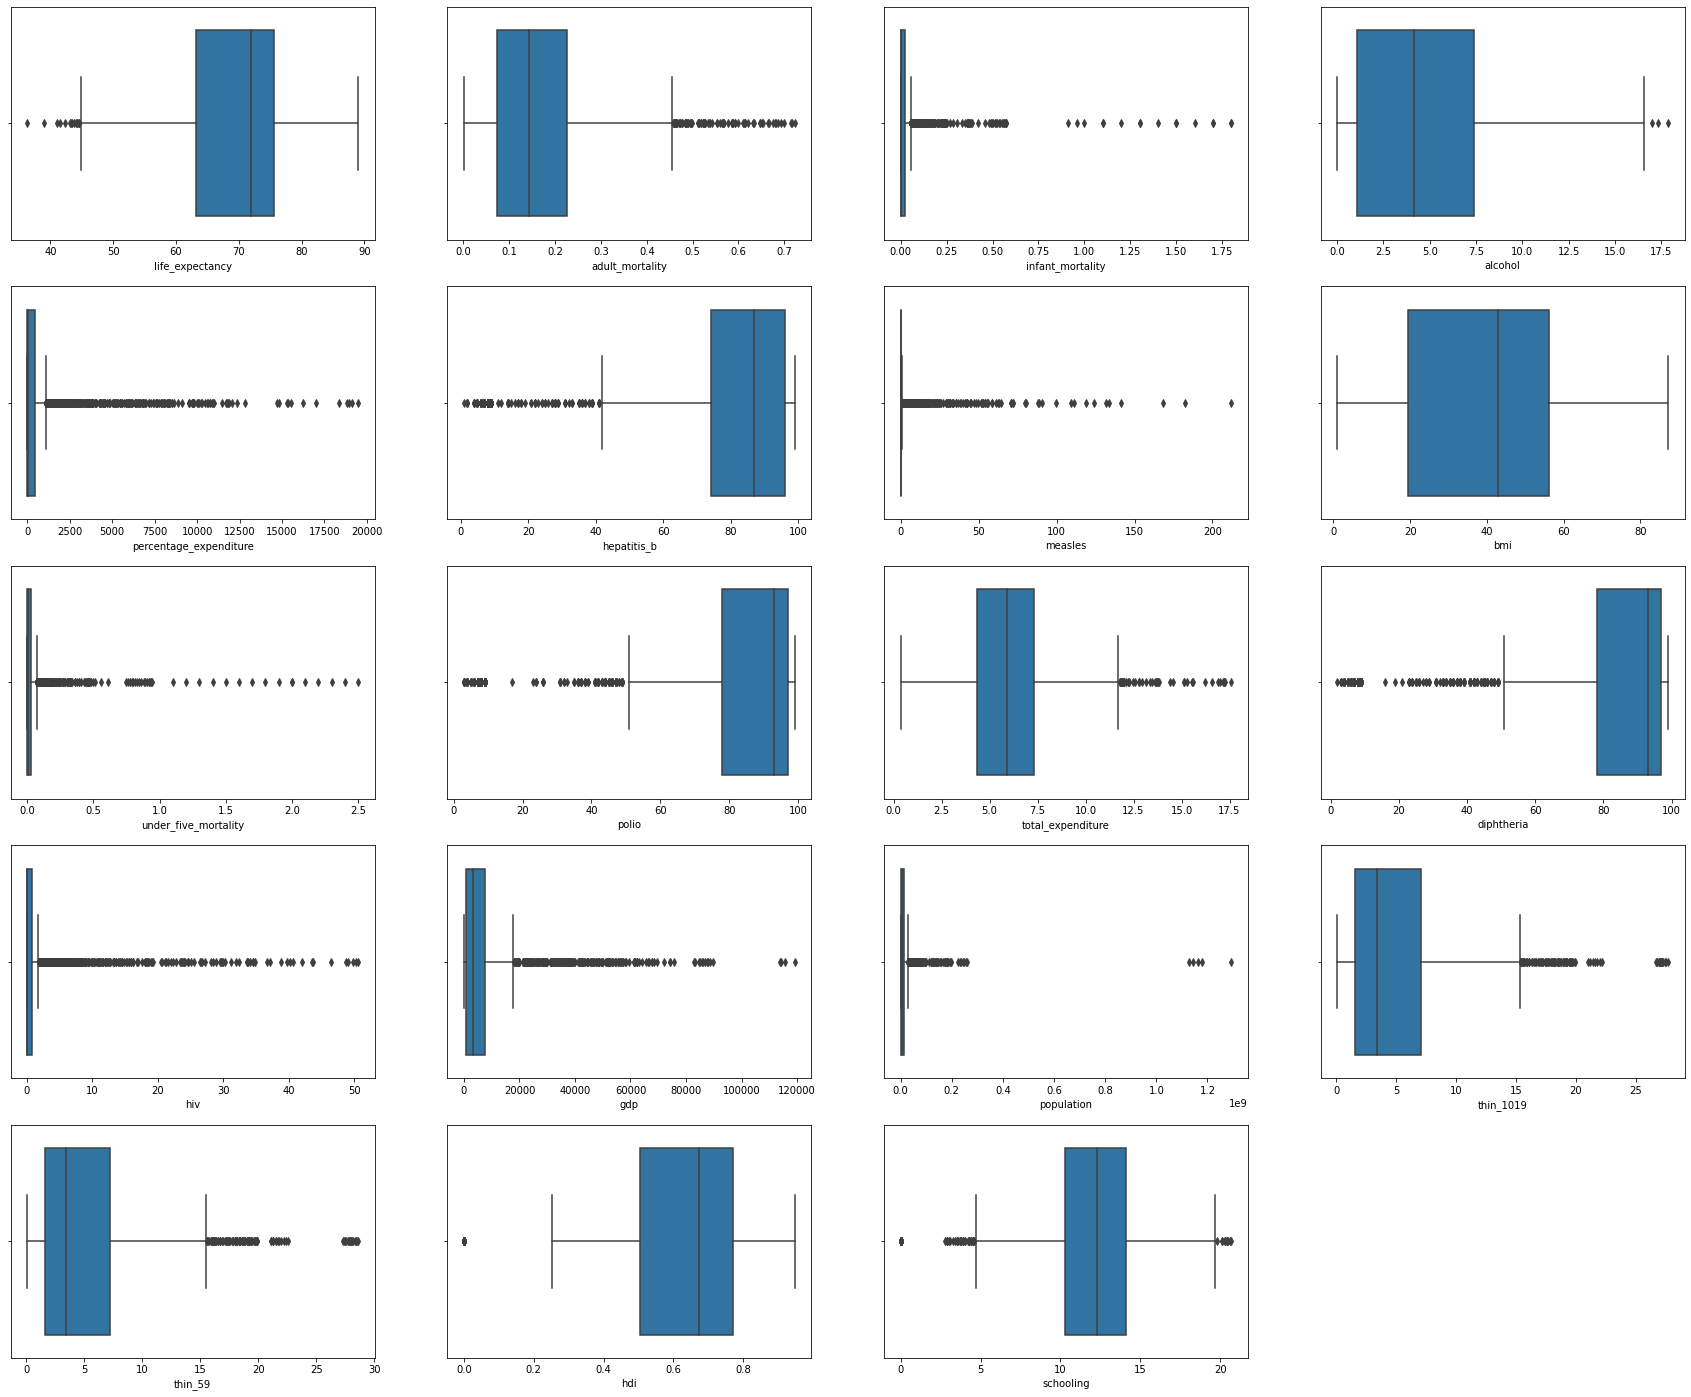

In [13]:
# boxplot 도출
%matplotlib inline

cols_list = list(df.columns)[3:]
make_boxplot(df, cols_list)

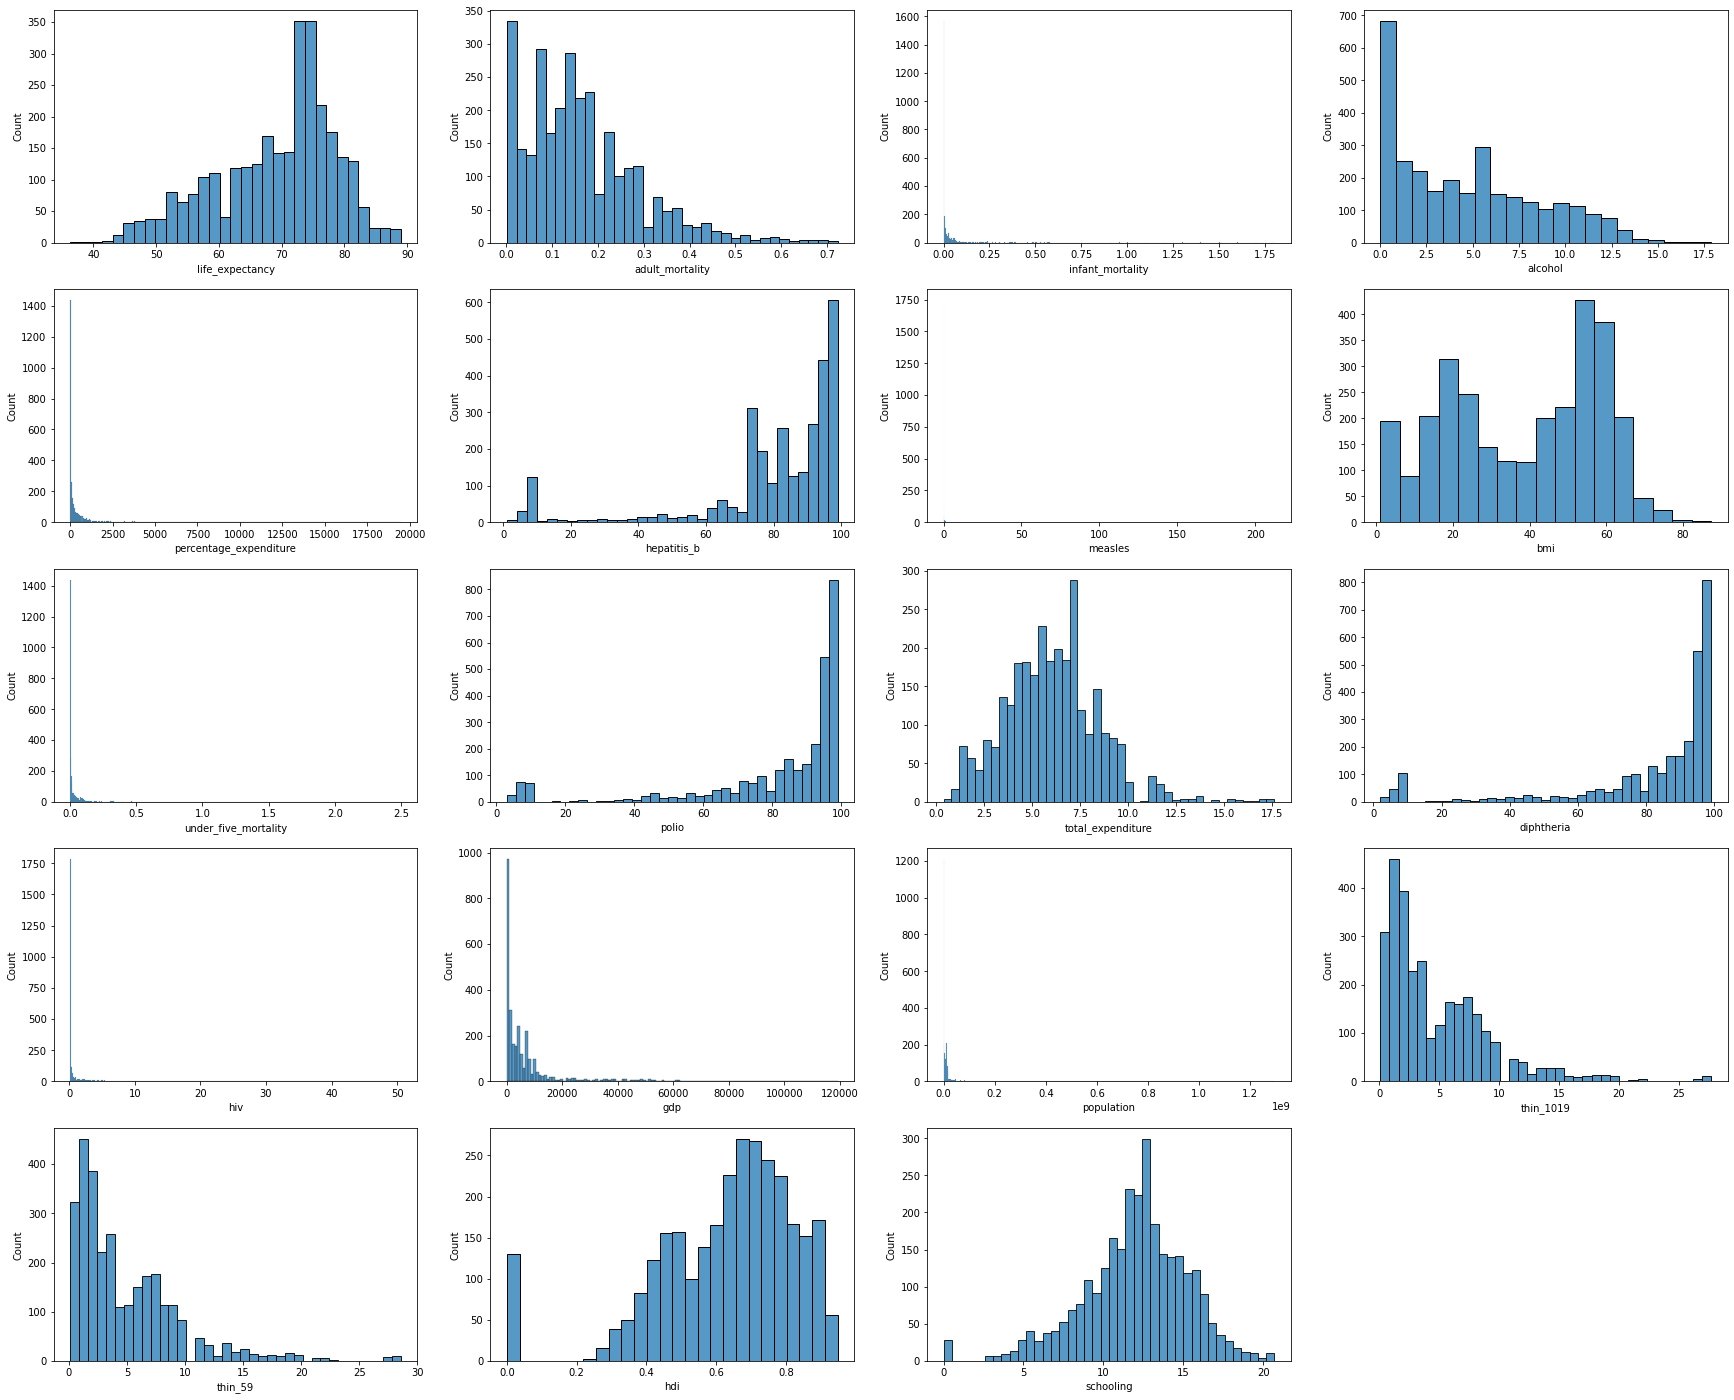

In [14]:
# 히스토그램
make_histogram(df, cols_list)

#### ✅ 이상치 제거
- 이상치 처리를 위해 `winsorization` 실시

    방법 1) 이상치를 그냥 제거하는 방법: 가장 간단하고 best <-> 그러나 데이터 손실이 발생하고, 데이터의 설명력도 떨어질 수 있다.

    방법 2) winsorization: 극단 값을 특정 값으로 대체하는 방법으로, 예를 들어 상위 99%을 넘는 데이터는 99%의 값으로 대체한다.

In [14]:
# 각 feature마다 이상치의 비중이 얼마나 되는지 파악하는 함수 생성
def outlier(col, df):
    q75, q25 = np.percentile(df[col], [75, 25])
    iqr = q75 - q25
    min_val = q25 - (iqr*1.5)
    max_val = q75 + (iqr*1.5)

    # 아래 len() = array([ 798, 1630, 1632, 1633]),)이기 때문에 [0]의 length를 구해서 이상치가 몇 개인지 파악
    cnt = len(np.where((df[col] > max_val) | (df[col] < min_val))[0]) 
    percent = round(cnt/len(df[col])*100, 2)

    print('"' + col + '"' + ' Percent of outlier: {}%'.format(percent))

In [15]:
# 이상치 비중 파악하기
for c in cols_list:
    outlier(c, df)

"life_expectancy" Percent of outlier: 0.58%
"adult_mortality" Percent of outlier: 2.93%
"infant_mortality" Percent of outlier: 10.72%
"alcohol" Percent of outlier: 0.1%
"percentage_expenditure" Percent of outlier: 13.24%
"hepatitis_b" Percent of outlier: 7.56%
"measles" Percent of outlier: 18.45%
"bmi" Percent of outlier: 0.0%
"under_five_mortality" Percent of outlier: 13.41%
"polio" Percent of outlier: 9.5%
"total_expenditure" Percent of outlier: 1.74%
"diphtheria" Percent of outlier: 10.14%
"hiv" Percent of outlier: 18.45%
"gdp" Percent of outlier: 10.21%
"population" Percent of outlier: 6.91%
"thin_1019" Percent of outlier: 3.4%
"thin_59" Percent of outlier: 3.37%
"hdi" Percent of outlier: 4.42%
"schooling" Percent of outlier: 2.62%


In [16]:
# winsorize하지 않는 데이터는 df에서 그대로 가져와 not_wins에 따로 저장해두기
not_wins = pd.DataFrame()
not_wins = pd.concat([df.iloc[:, 0:3], df.iloc[:, 10]], axis=1)
not_wins.head(3)

,country,year,status,bmi
0,Afghanistan,2015,Developing,19.1
16,Albania,2015,Developing,58.0
32,Algeria,2015,Developing,59.5


In [17]:
# wisorization 함수 생성
def wins(col, data, limit):
    winsor_data = winsorize(data[col], limits=limit)
    wins_dict[col] =  winsor_data


cols_list.remove('bmi')     # cols_list에서 BMI 제거하기
wins_list = cols_list      # 헷갈리니까 이름 다르게 해주기
wins_dict = {} 

In [18]:
# df2: winsorization으로 이상치 제거하기
wins('life_expectancy', df, limit=(0.01, 0.01))
wins('adult_mortality', df, limit=(0.03, 0.03))
wins('infant_mortality', df, limit=(0.11, 0.11))
wins('alcohol', df, limit=(0.015, 0.015))
wins('percentage_expenditure', df, limit=(0.14, 0.14))
wins('hepatitis_b', df, limit=(0.08, 0.08))
wins('measles', df, limit=(0.2, 0.2))
wins('under_five_mortality', df, limit=(0.14, 0.14))
wins('polio', df, limit=(0.1, 0.1))
wins('total_expenditure', df, limit=(0.02, 0.02))
wins('diphtheria', df, limit=(0.11, 0.11))
wins('hiv', df, limit=(0.19, 0.19))
wins('gdp', df, limit=(0.11, 0.11))
wins('population', df, limit=(0.07, 0.07))
wins('thin_1019', df, limit=(0.04, 0.04))
wins('thin_59', df, limit=(0.04, 0.04))
wins('hdi', df, limit=(0.05, 0.05))
wins('schooling', df, limit=(0.03, 0.03))

# winsorize한 데이터를 wins_df에 저장
wins_df = not_wins
for col in wins_list:
    wins_df[col] = wins_dict[col]

/Users/minky/opt/anaconda3/envs/cp2/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/minky/opt/anaconda3/envs/cp2/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/minky/opt/anaconda3/envs/cp2/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misi

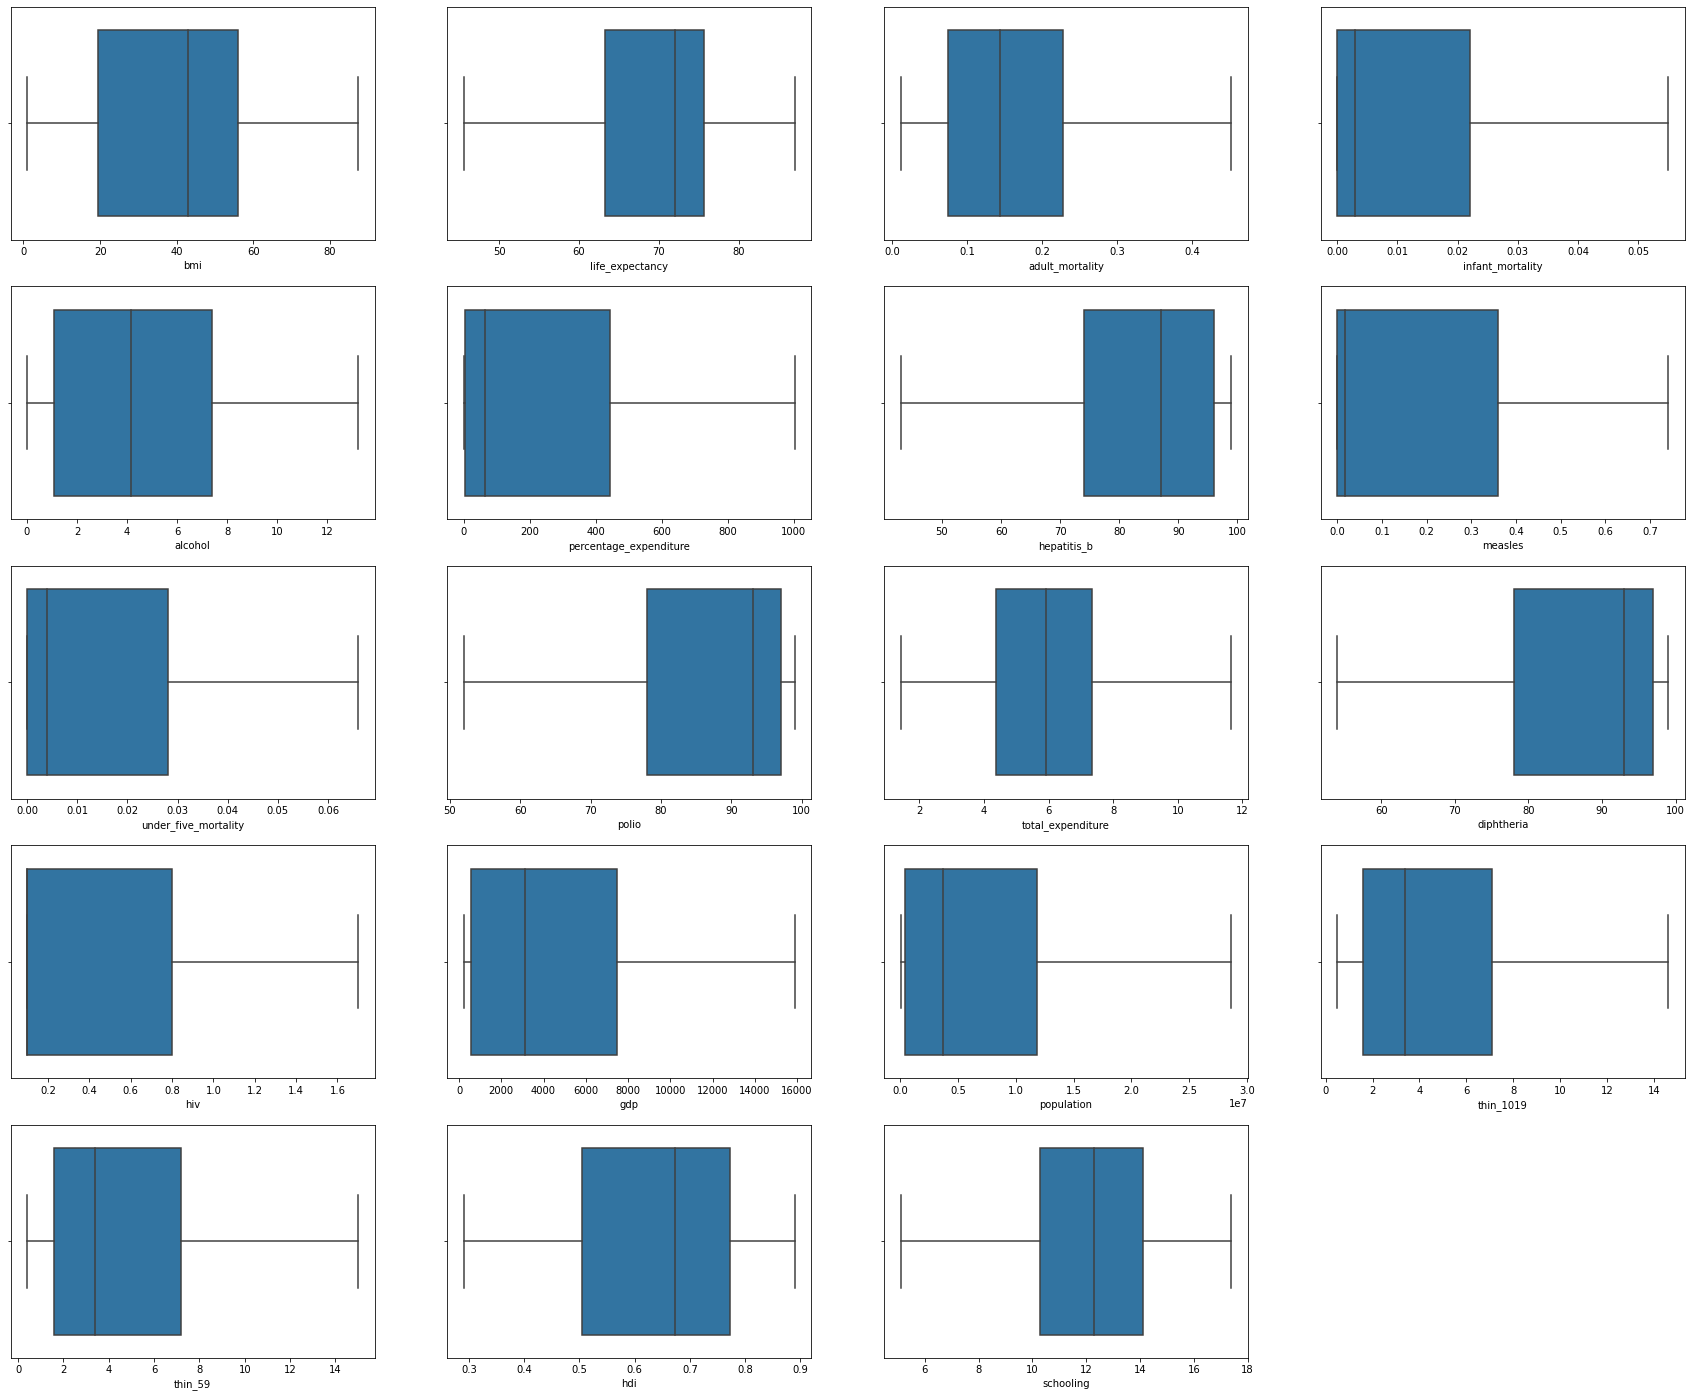

In [20]:
# winsorization 후 boxplot 확인
make_boxplot(wins_df, list(wins_df.columns[3:]))

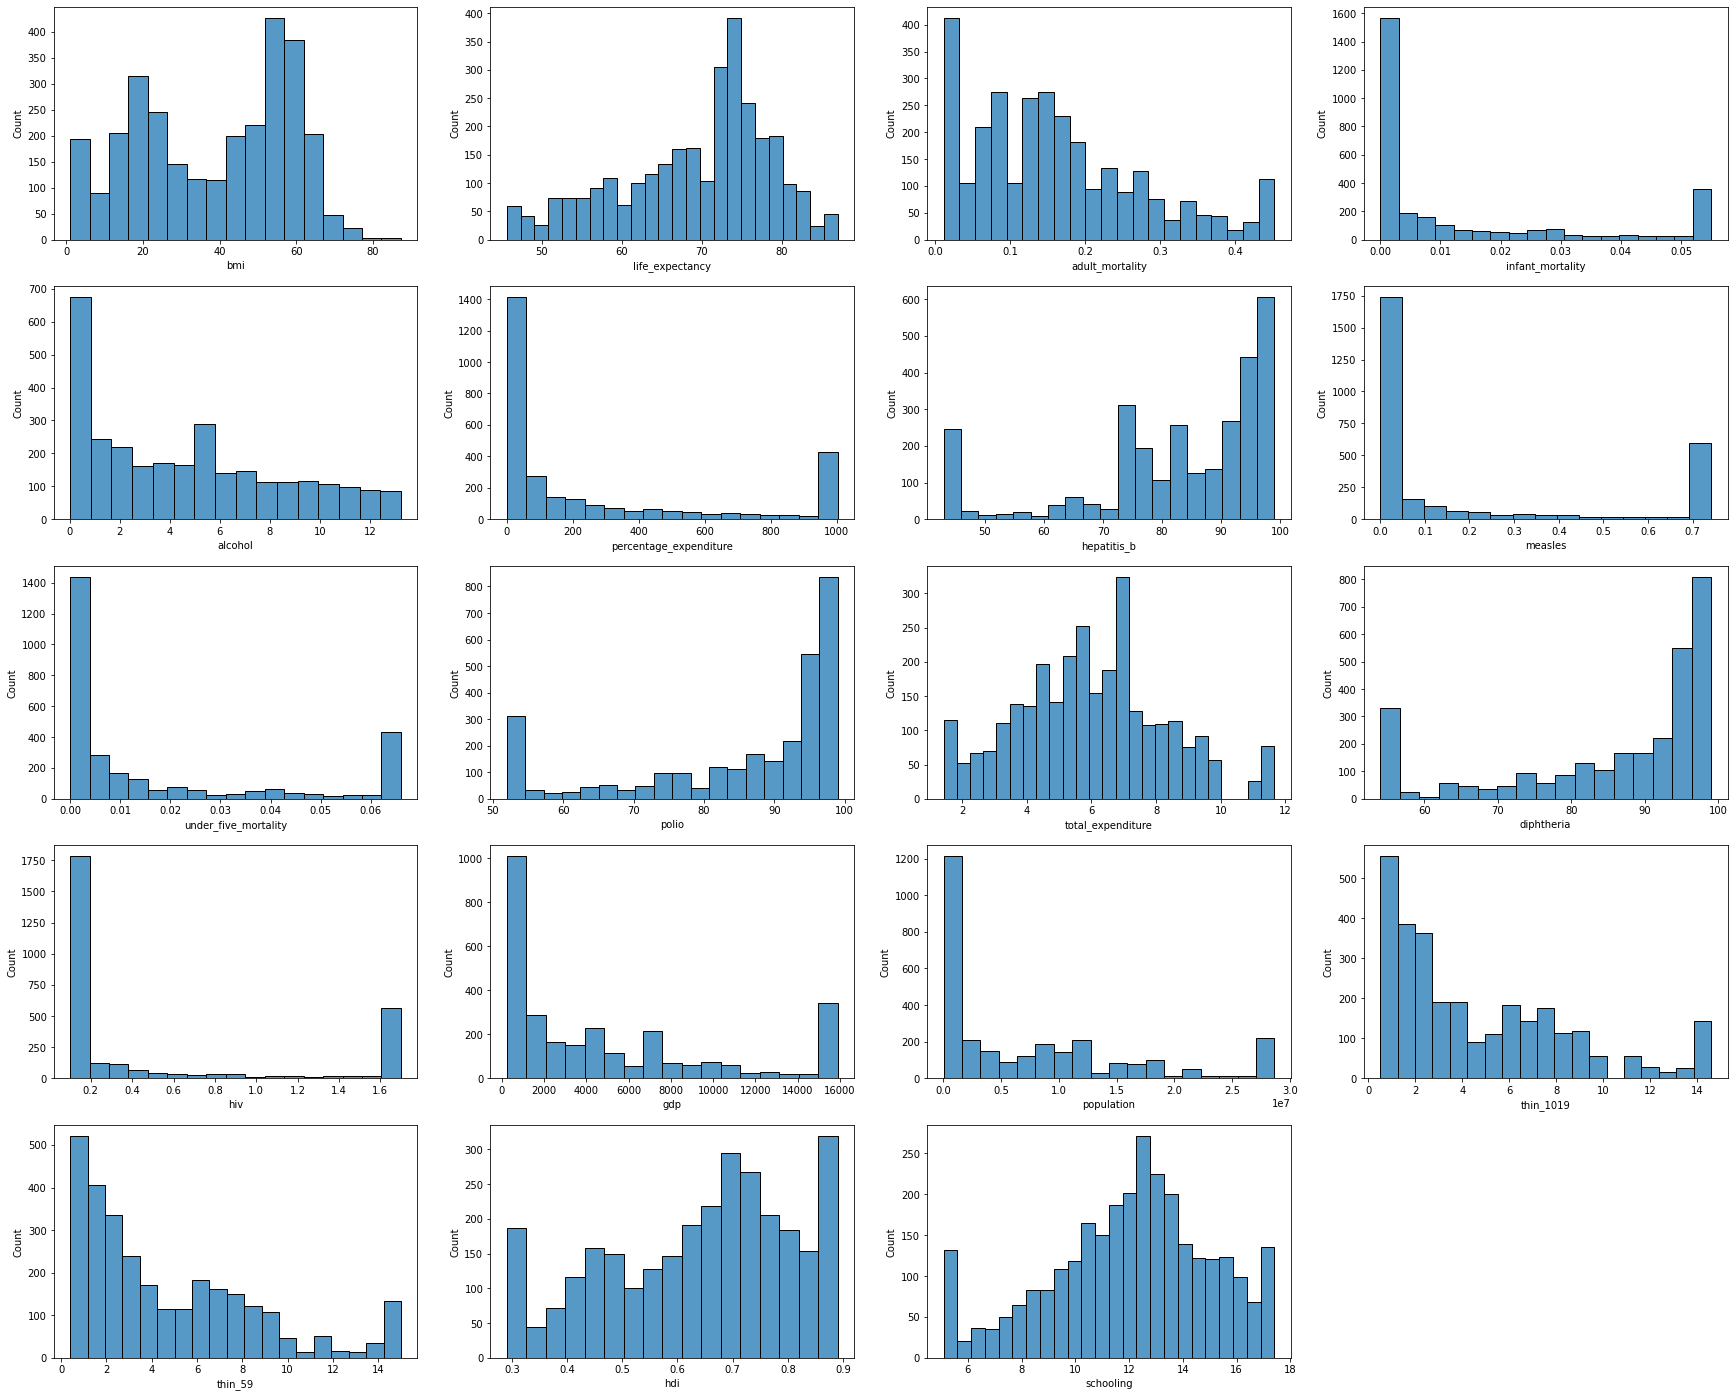

In [ ]:
# 히스토그램으로도 살펴보기
make_histogram(wins_df, list(wins_df.columns[3:]))

## 3. EDA
`winsorization`까지 거친 데이터셋을 가지고 각 feature의 value가 어떻게 이루어져있는지 등과 같은 특징을 시각화를 통해 파악한다.

### 3-1. Categorical 변수 
    
    - country
    - year
    - status

에 대한 EDA 과정 진행

In [ ]:
# country 개수
wins_df['country'].value_counts()

Afghanistan         16
Philippines         16
Niger               16
Nigeria             16
Norway              16
                    ..
Nauru                1
Monaco               1
Marshall Islands     1
Dominica             1
Tuvalu               1
Name: country, Length: 193, dtype: int64

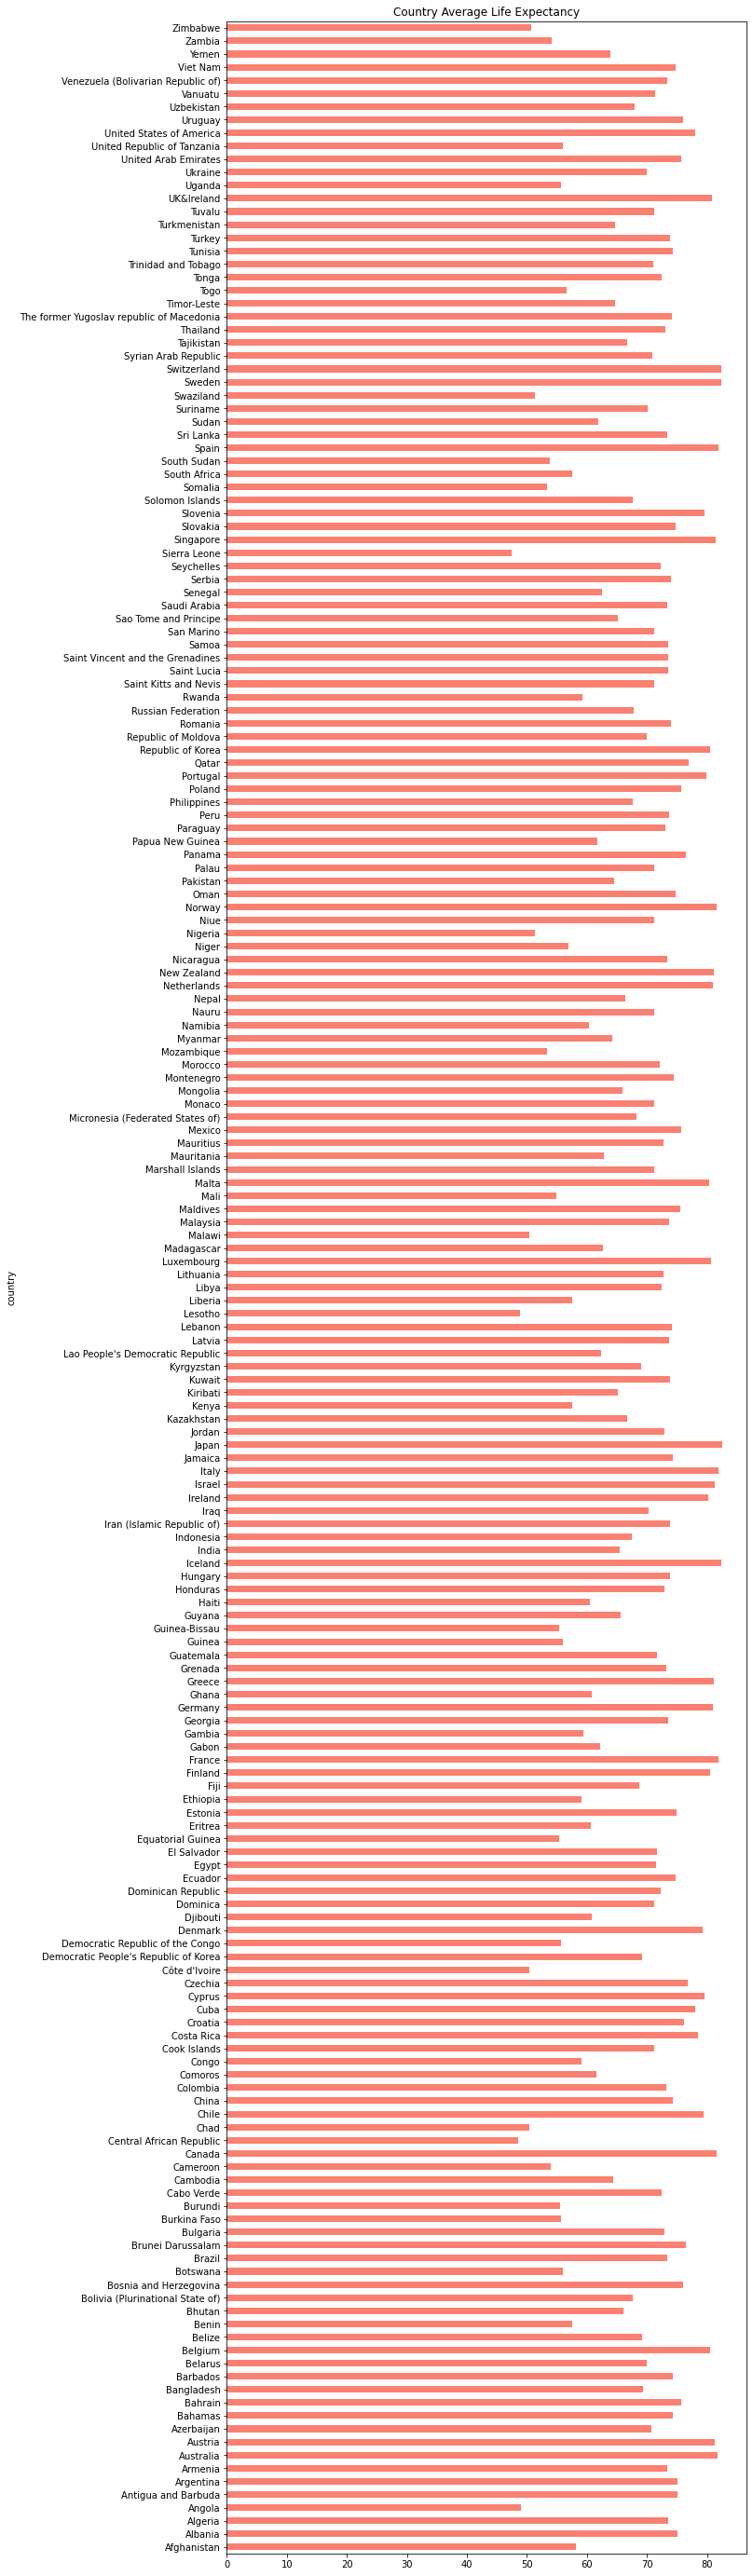

In [ ]:
# country: 나라별 평균 기대수명을 나타낸 barh plot 구현
wins_df.groupby('country').life_expectancy.mean().plot(kind='barh', figsize=(10,50), color='#FA8072')
plt.title('Country Average Life Expectancy');

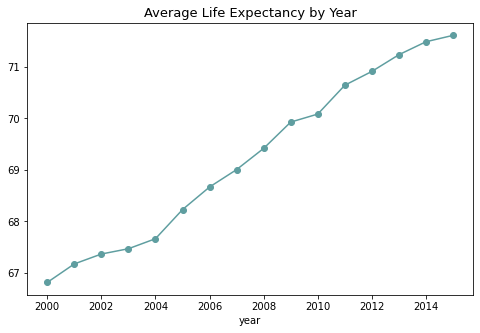

In [ ]:
# year: barplot으로 연도별 평균 기대 수명 그리기
wins_df.groupby('year').life_expectancy.mean().plot(kind = 'line', marker='o', figsize=(8,5), color='#5F9EA0')
plt.title('Average Life Expectancy by Year', fontsize=13);

Developing    2426
Developed      512
Name: status, dtype: int64
------------------------------


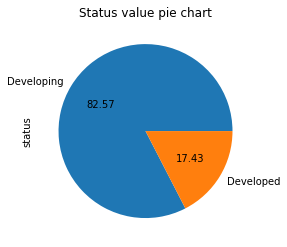

In [ ]:
# status: 변수의 value가 두 개이므로, 각 비중을 pie chart로 시각화
print(wins_df['status'].value_counts()) 

print('-'*30)

wins_df['status'].value_counts().plot(kind='pie', autopct='%.2f')   # developing인 국가가 약 83%이고, developed인 국가는 약 17%
plt.title('Status value pie chart');

### 3-2. 연속형 변수
    - bmi
    - adult_mortality
    - infant_mortality
    - alcohol
    - percentage_expenditure
    - hepatitis_b
    - measles
    - under-five_mortality
    - polio
    - total_expenditure
    - diphtheria
    - hiv/aids
    - gdp
    - population
    - thin_10-19
    - thin_5-9
    - hdi
    - schooling

에 대한 EDA 과정을 진행

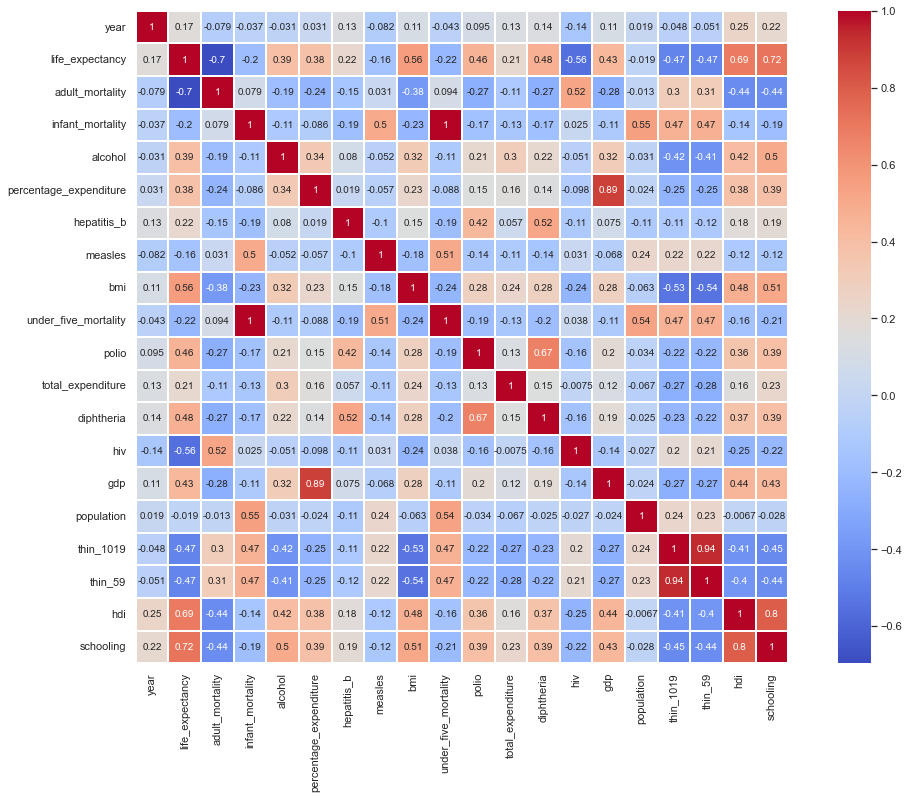

In [39]:
# 연속형 변수들 간의 상관관계 파악하기 위한 heatmap
h_cols = df.drop(['country','status'],axis=1).columns   # value가 category인 두 feature는 제외
sns.set(rc = {'figure.figsize':(18,12)})
sns.heatmap(df[h_cols].astype(float).corr(), linewidths = 0.1, vmax = 1.0, cmap='coolwarm', square = True, linecolor = "white", annot = True, annot_kws = {"size" : 10});

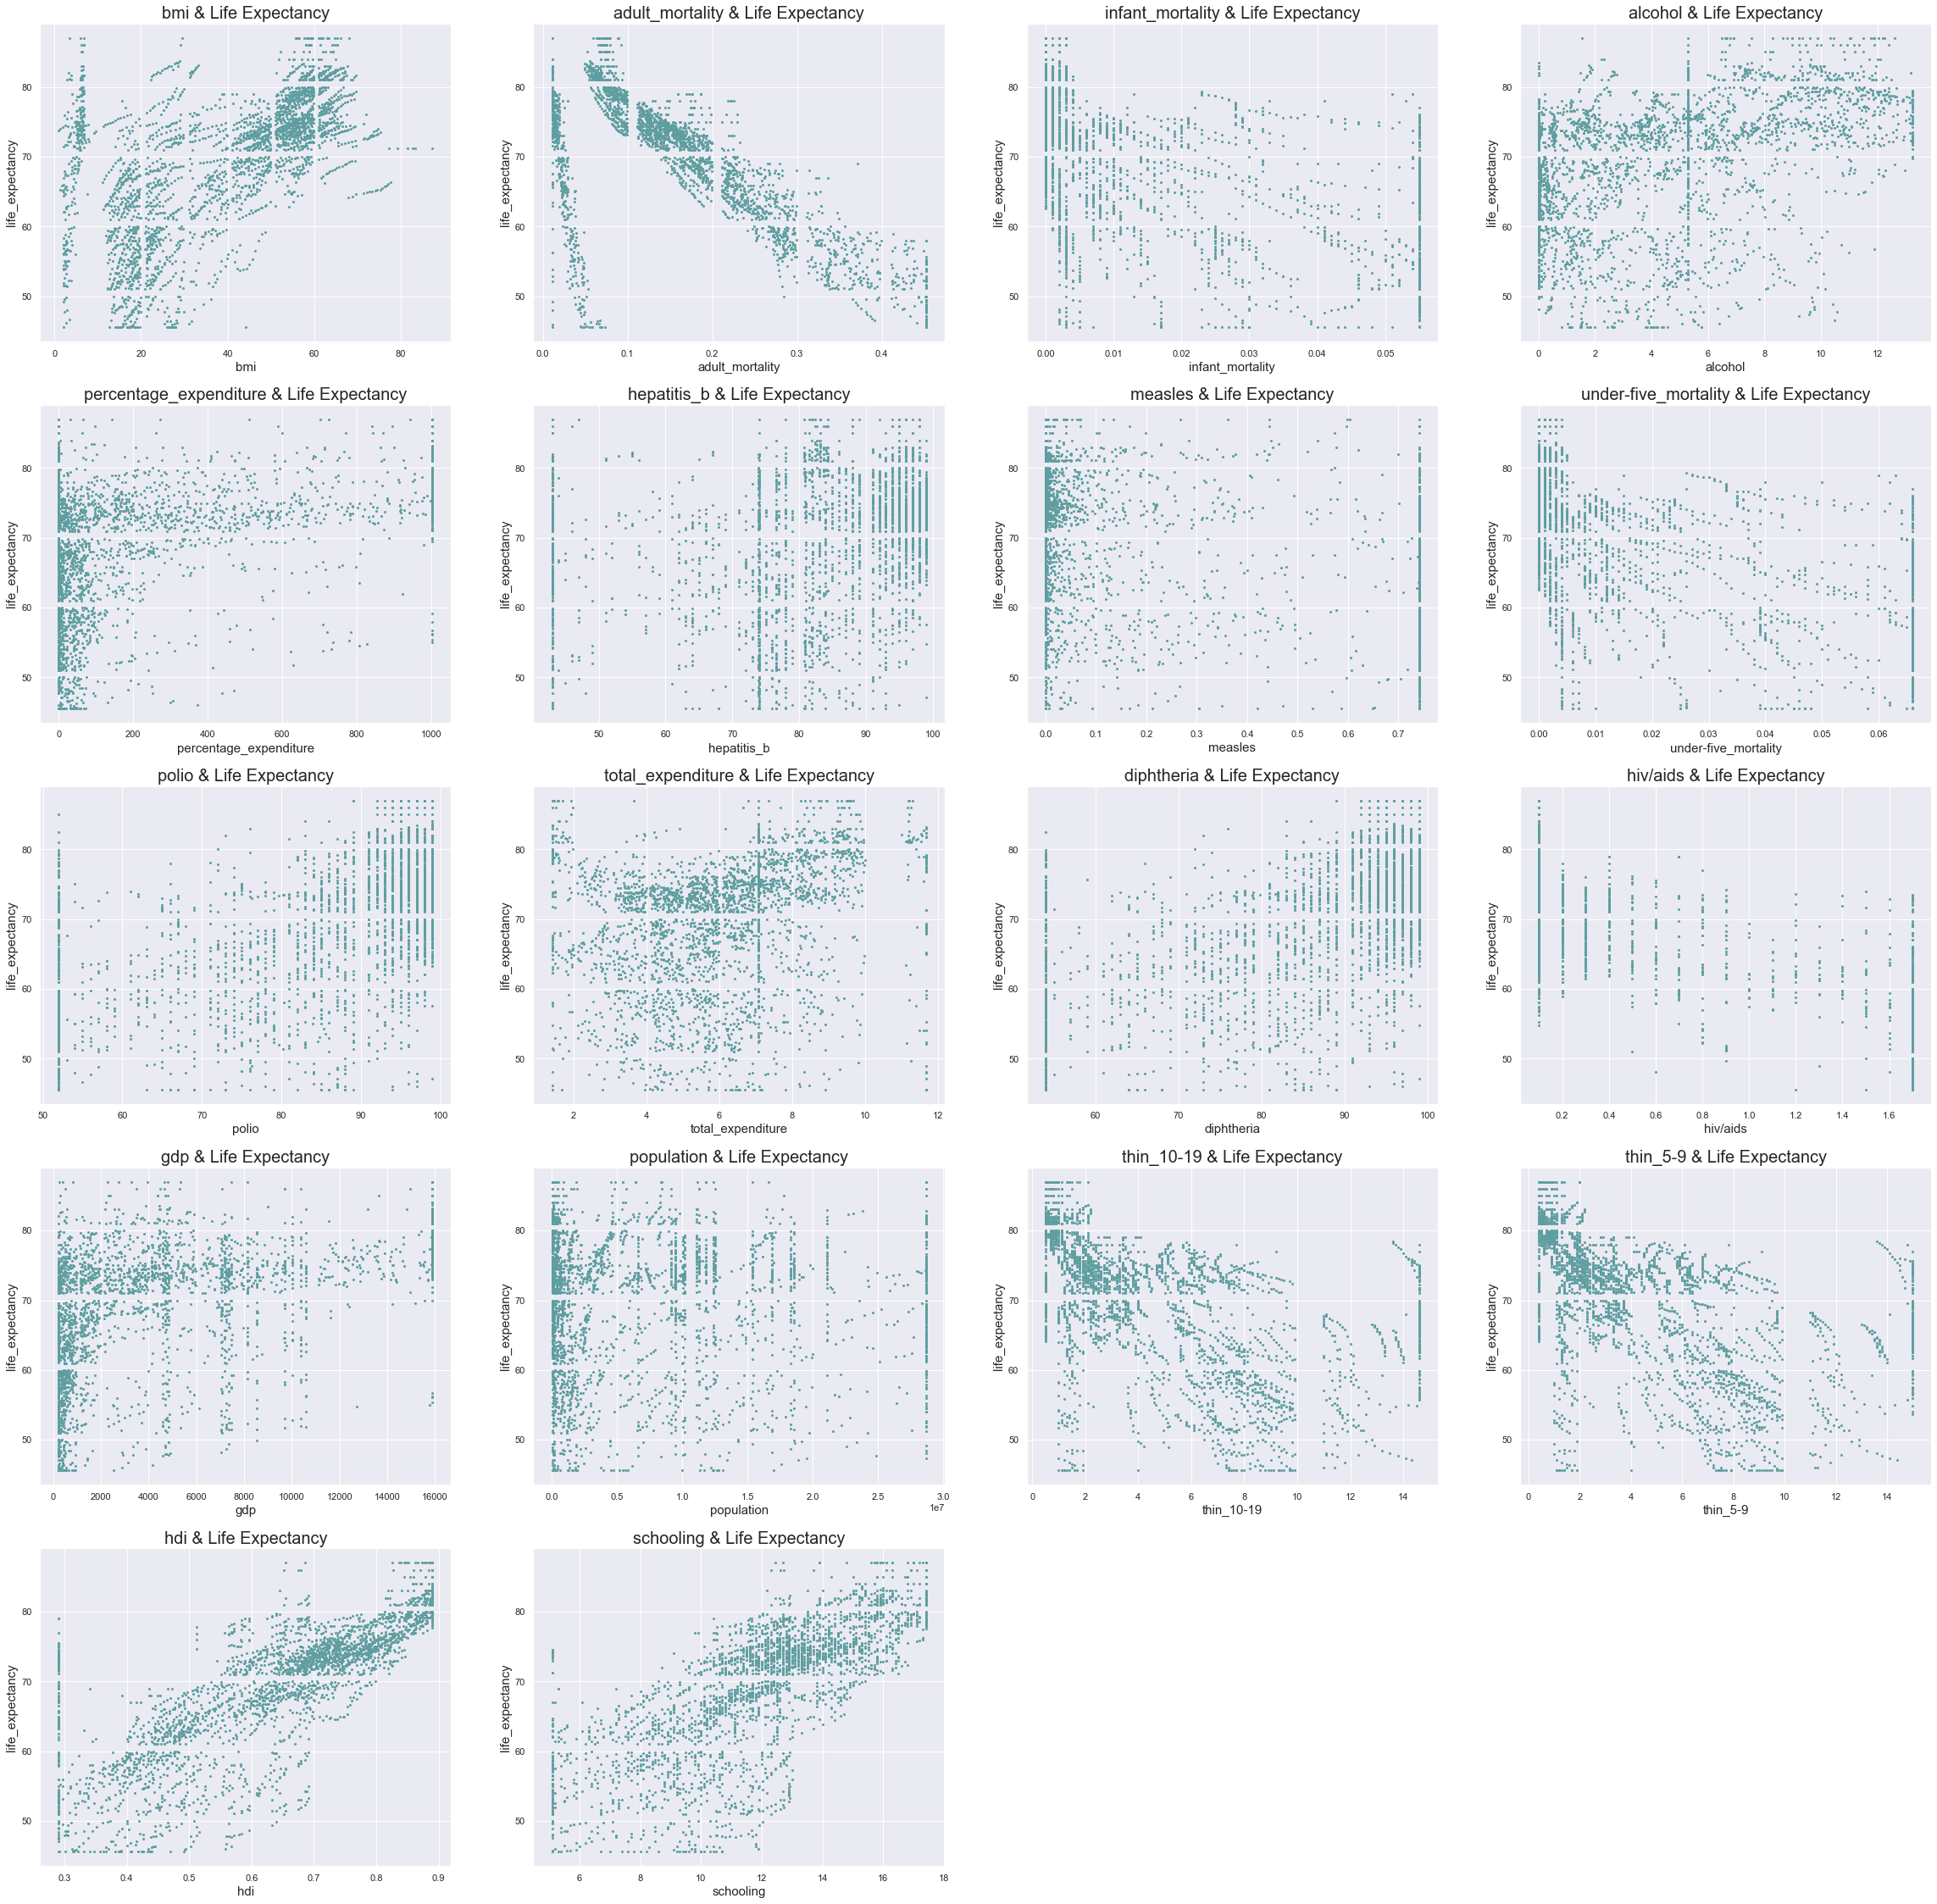

In [ ]:
# 각 연속형 변수에 따른 기대수명 변화를 산점도로 살펴보기
wincol_list = wins_df.drop(['life_expectancy', 'country', 'year', 'status'],axis=1).columns

def make_scatter(df, list):
    plt.figure(figsize=(40, 40))
    x=0

    for n in list:
        x += 1
        plt.subplot(5, 4, x)
        plt.scatter(df[n], df['life_expectancy'], s = 4, color='#5F9EA0')
        plt.title('{} & Life Expectancy'.format(n), fontsize=20) 
        plt.xlabel('{}'.format(n), fontsize=15)
        plt.ylabel('life_expectancy', fontsize=15)
    plt.show();

make_scatter(wins_df, wincol_list)

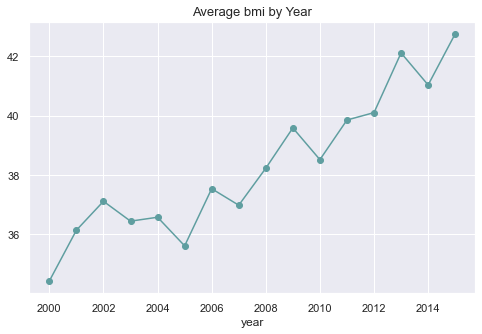

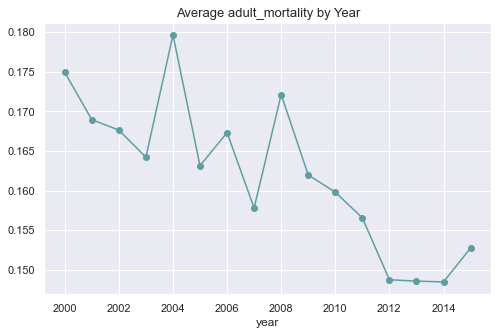

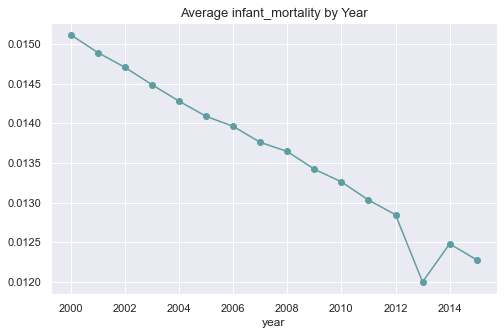

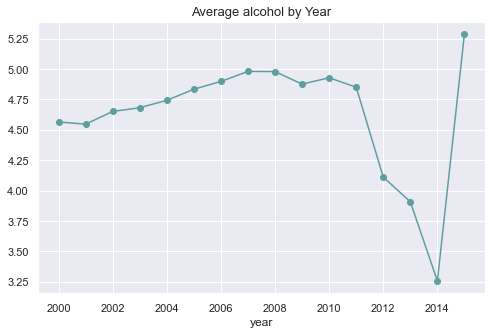

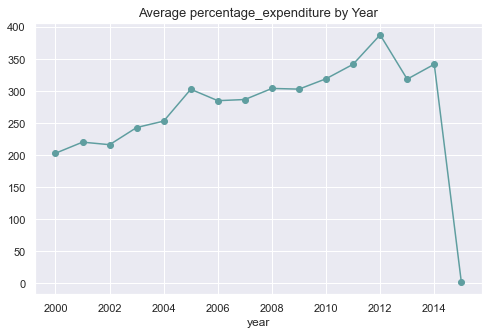

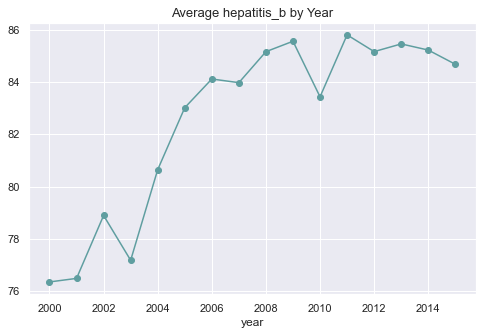

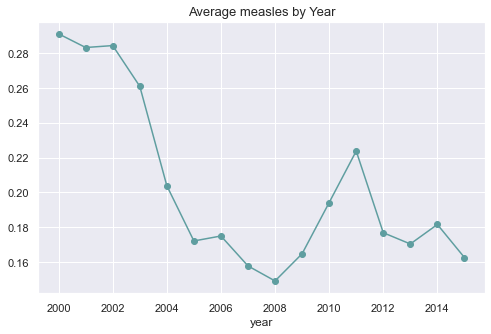

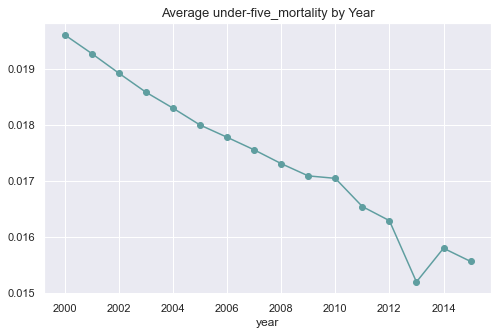

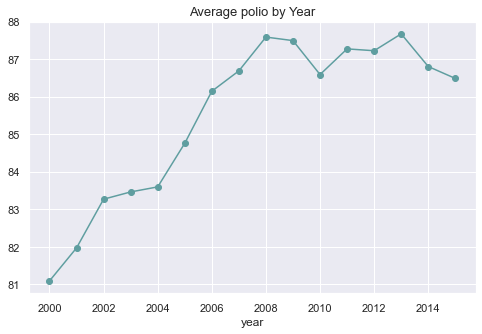

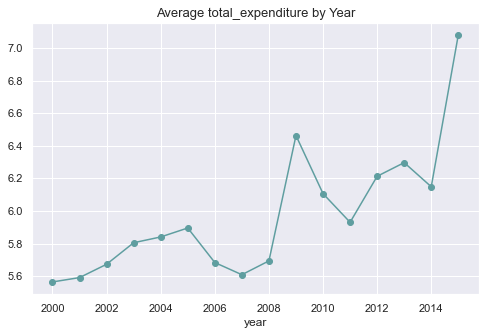

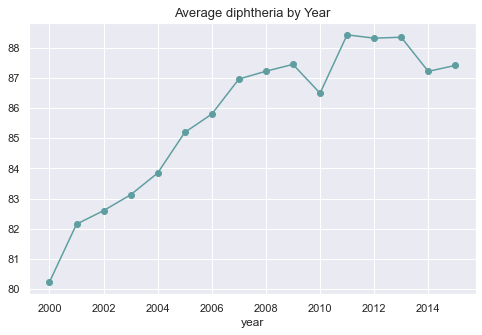

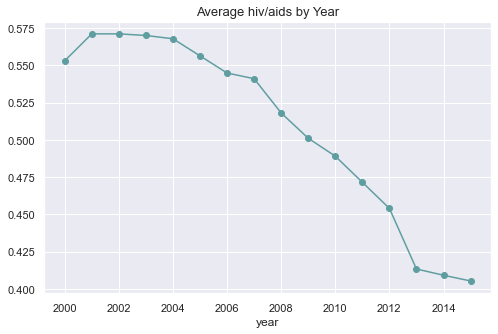

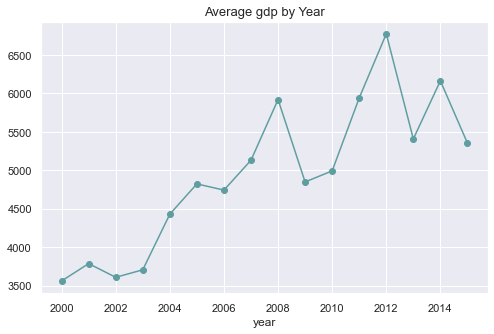

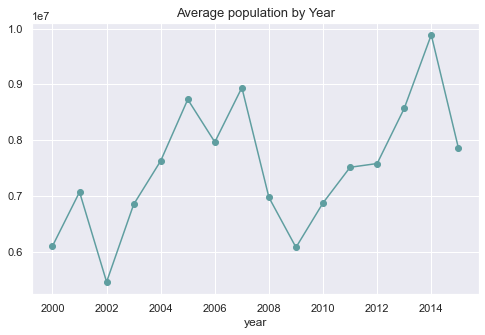

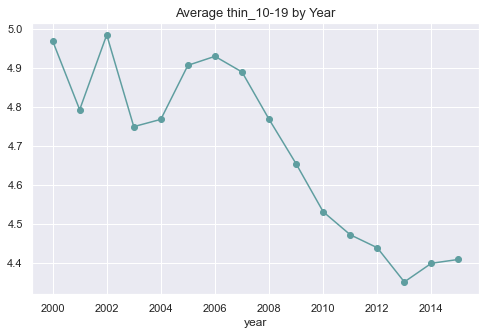

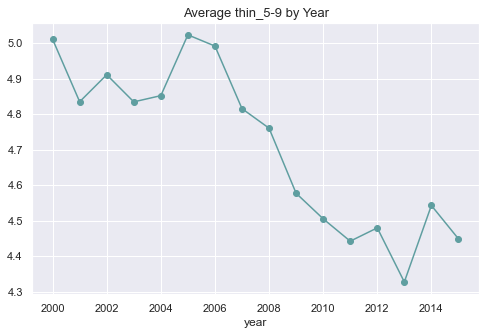

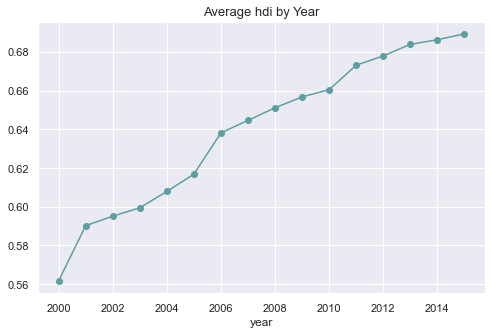

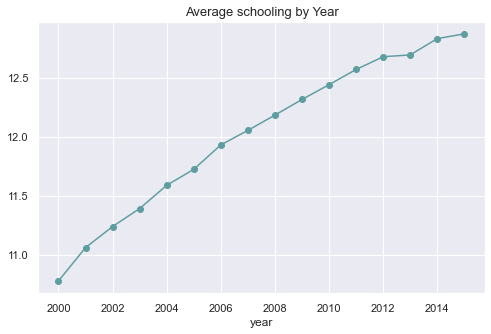

In [ ]:
# 각 연속형 변수의 연도별 변화 추이
wincol_list = wins_df.drop(['life_expectancy', 'country', 'year', 'status'],axis=1).columns

plt.figure(figsize=(10, 10))
wins_df.groupby('year').bmi.mean().plot(kind = 'line', marker='o', figsize=(8,5), color='#5F9EA0')
plt.title('Average bmi by Year', fontsize=13)

plt.figure(figsize=(10, 10))
wins_df.groupby('year').adult_mortality.mean().plot(kind = 'line', marker='o', figsize=(8,5), color='#5F9EA0')
plt.title('Average adult_mortality by Year', fontsize=13)

plt.figure(figsize=(10, 10))
wins_df.groupby('year').infant_mortality.mean().plot(kind = 'line', marker='o', figsize=(8,5), color='#5F9EA0')
plt.title('Average infant_mortality by Year', fontsize=13)

plt.figure(figsize=(10, 10))
wins_df.groupby('year').alcohol.mean().plot(kind = 'line', marker='o', figsize=(8,5), color='#5F9EA0')
plt.title('Average alcohol by Year', fontsize=13)

plt.figure(figsize=(10, 10))
wins_df.groupby('year').percentage_expenditure.mean().plot(kind = 'line', marker='o', figsize=(8,5), color='#5F9EA0')
plt.title('Average percentage_expenditure by Year', fontsize=13)

plt.figure(figsize=(10, 10))
wins_df.groupby('year').hepatitis_b.mean().plot(kind = 'line', marker='o', figsize=(8,5), color='#5F9EA0')
plt.title('Average hepatitis_b by Year', fontsize=13)

plt.figure(figsize=(10, 10))
wins_df.groupby('year').measles.mean().plot(kind = 'line', marker='o', figsize=(8,5), color='#5F9EA0')
plt.title('Average measles by Year', fontsize=13)

plt.figure(figsize=(10, 10))
wins_df.groupby('year').under_five_mortality.mean().plot(kind = 'line', marker='o', figsize=(8,5), color='#5F9EA0')
plt.title('Average under-five_mortality by Year', fontsize=13)


plt.figure(figsize=(10, 10))
wins_df.groupby('year').polio.mean().plot(kind = 'line', marker='o', figsize=(8,5), color='#5F9EA0')
plt.title('Average polio by Year', fontsize=13)

plt.figure(figsize=(10, 10))
wins_df.groupby('year').total_expenditure.mean().plot(kind = 'line', marker='o', figsize=(8,5), color='#5F9EA0')
plt.title('Average total_expenditure by Year', fontsize=13)


plt.figure(figsize=(10, 10))
wins_df.groupby('year').diphtheria.mean().plot(kind = 'line', marker='o', figsize=(8,5), color='#5F9EA0')
plt.title('Average diphtheria by Year', fontsize=13)


plt.figure(figsize=(10, 10))
wins_df.groupby('year').hiv.mean().plot(kind = 'line', marker='o', figsize=(8,5), color='#5F9EA0')
plt.title('Average hiv/aids by Year', fontsize=13)

plt.figure(figsize=(10, 10))
wins_df.groupby('year').gdp.mean().plot(kind = 'line', marker='o', figsize=(8,5), color='#5F9EA0')
plt.title('Average gdp by Year', fontsize=13)

plt.figure(figsize=(10, 10))
wins_df.groupby('year').population.mean().plot(kind = 'line', marker='o', figsize=(8,5), color='#5F9EA0')
plt.title('Average population by Year', fontsize=13)

plt.figure(figsize=(10, 10))
wins_df.groupby('year').thin_1019.mean().plot(kind = 'line', marker='o', figsize=(8,5), color='#5F9EA0')
plt.title('Average thin_10-19 by Year', fontsize=13)

plt.figure(figsize=(10, 10))
wins_df.groupby('year').thin_59.mean().plot(kind = 'line', marker='o', figsize=(8,5), color='#5F9EA0')
plt.title('Average thin_5-9 by Year', fontsize=13)

plt.figure(figsize=(10, 10))
wins_df.groupby('year').hdi.mean().plot(kind = 'line', marker='o', figsize=(8,5), color='#5F9EA0')
plt.title('Average hdi by Year', fontsize=13)

plt.figure(figsize=(10, 10))
wins_df.groupby('year').schooling.mean().plot(kind = 'line', marker='o', figsize=(8,5), color='#5F9EA0')
plt.title('Average schooling by Year', fontsize=13)

plt.show();

### 3-3. 각 연도별 기대수명이 가장 긴 나라 top 5 시각화
- 각 연도별로 기대수명이 가장 긴 top5를 추출해 시각화해본다.

In [ ]:
# (1) 각 연도별 기대수명 top 5의 국가/기대수명/년도를 리스트에 저장
top_5 = []
year_list = list(wins_df['year'].unique())
for i in year_list:
    top5 = wins_df[wins_df['year'] == i].nlargest(5, 'life_expectancy')[['country', 'life_expectancy', 'year']]
    top_5.append(top5)

top5_2015 = pd.DataFrame(top_5[0], columns = ['country', 'life_expectancy', 'year'])
top5_2014 = pd.DataFrame(top_5[1], columns = ['country', 'life_expectancy', 'year'])
top5_2013 = pd.DataFrame(top_5[2], columns = ['country', 'life_expectancy', 'year'])
top5_2012 = pd.DataFrame(top_5[3], columns = ['country', 'life_expectancy', 'year'])
top5_2011 = pd.DataFrame(top_5[4], columns = ['country', 'life_expectancy', 'year'])
top5_2010 = pd.DataFrame(top_5[5], columns = ['country', 'life_expectancy', 'year'])
top5_2009 = pd.DataFrame(top_5[6], columns = ['country', 'life_expectancy', 'year'])
top5_2008 = pd.DataFrame(top_5[7], columns = ['country', 'life_expectancy', 'year'])
top5_2007 = pd.DataFrame(top_5[8], columns = ['country', 'life_expectancy', 'year'])
top5_2006 = pd.DataFrame(top_5[9], columns = ['country', 'life_expectancy', 'year'])
top5_2005 = pd.DataFrame(top_5[10], columns = ['country', 'life_expectancy', 'year'])
top5_2004 = pd.DataFrame(top_5[11], columns = ['country', 'life_expectancy', 'year'])
top5_2003 = pd.DataFrame(top_5[12], columns = ['country', 'life_expectancy', 'year'])
top5_2002 = pd.DataFrame(top_5[13], columns = ['country', 'life_expectancy', 'year'])
top5_2001 = pd.DataFrame(top_5[14], columns = ['country', 'life_expectancy', 'year'])
top5_2000 = pd.DataFrame(top_5[15], columns = ['country', 'life_expectancy', 'year'])

# (3) 하나의 df로 병합
top5_li = [top5_2015, top5_2014, top5_2013, top5_2012, top5_2011, top5_2010, top5_2009, top5_2008, top5_2007, top5_2006, top5_2005, top5_2004, top5_2003, 
top5_2002, top5_2001, top5_2000]

top5_all = pd.concat(top5_li, ignore_index=True)
top5_all.head()

,country,life_expectancy,year
0,Slovenia,87.0,2015
1,Denmark,86.0,2015
2,Chile,85.0,2015
3,Cyprus,85.0,2015
4,Japan,83.7,2015


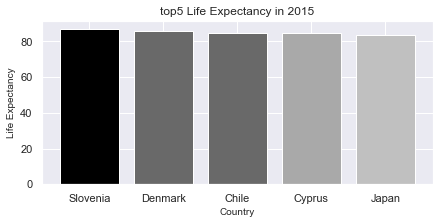

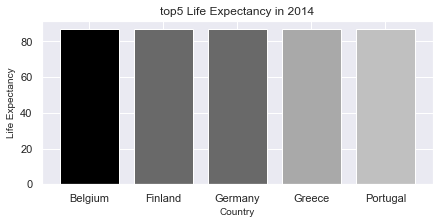

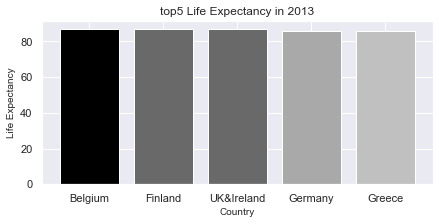

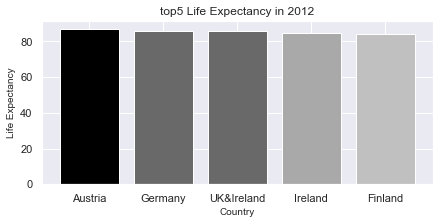

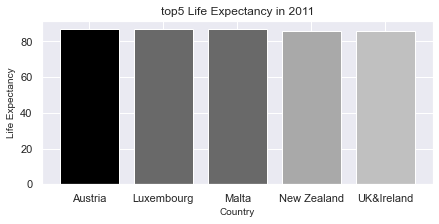

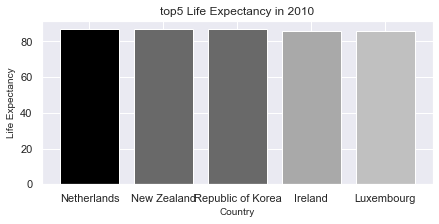

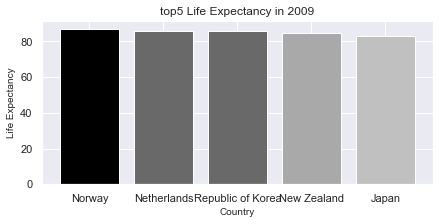

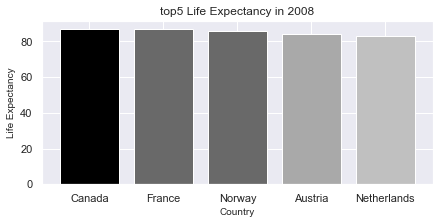

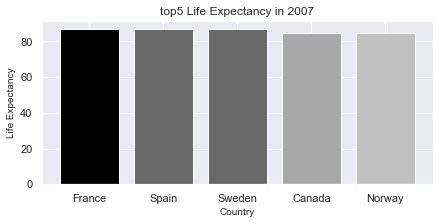

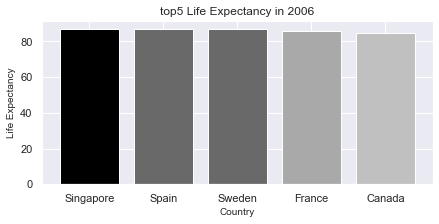

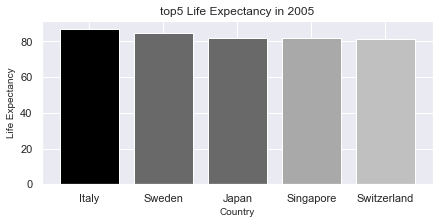

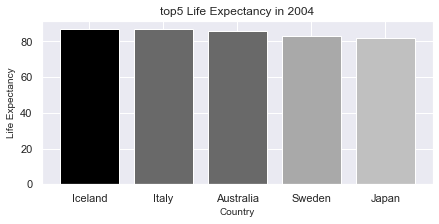

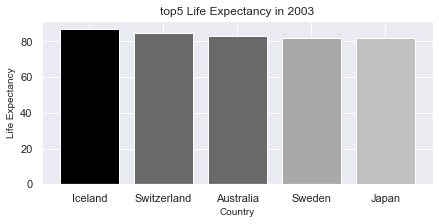

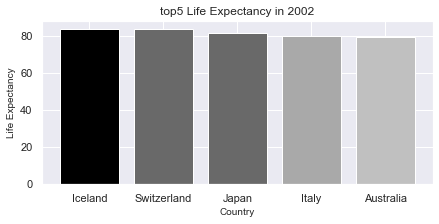

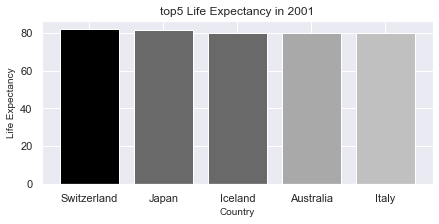

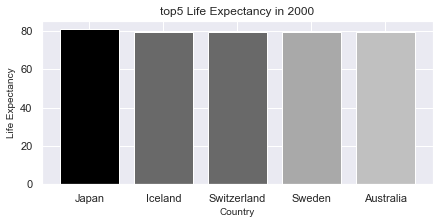

In [ ]:
# (4) 각 연도별 top5 시각화
# x=0
for y in year_list:
    plt.figure(figsize=(7, 3))
    colors = ['black','dimgray','dimgrey','darkgray','silver','lightgrey']

    # x += 1
    # plt.subplot(6, 3, x)

    plt.bar(top5_all[top5_all['year']==y].iloc[:, 0], top5_all[top5_all['year']==y].iloc[:, 1], color=colors)
    plt.title('top5 Life Expectancy in {}'.format(y), fontsize=12) 
    plt.xlabel('Country', fontsize=10)
    plt.ylabel('Life Expectancy', fontsize=10)
plt.show();

- 연도별 top5 그래프에서 4번 이상 등장한 국가들의 연도별 기대수명을 barplot으로 시각화하여 쉽게 파악해본다

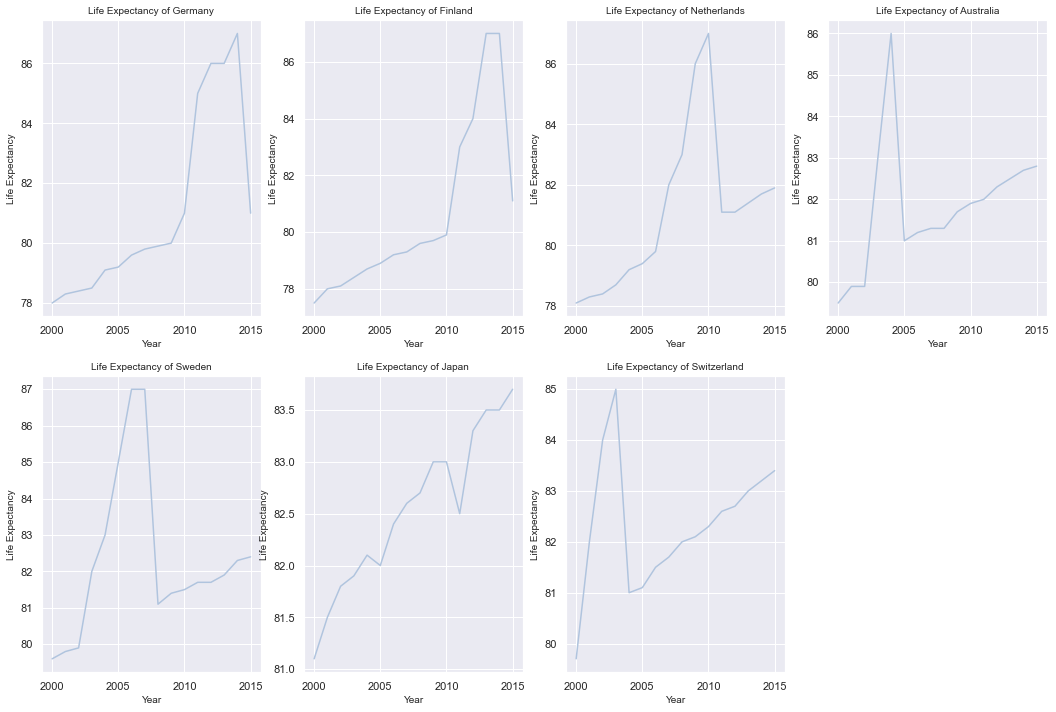

In [ ]:
# 해당 국가 명단 생성하기
countries = ['Germany', 'Finland', 'Netherlands', 'Australia', 'Sweden', 'Japan', 'Switzerland']

# barplot으로 각 국가 연도별 기대수명 시각화하기

x=0

for c in countries:
    x += 1
    plt.subplot(2, 4, x)

    top_df = wins_df[wins_df['country']== c][['year', 'life_expectancy']]
    plt.plot(top_df['year'], top_df['life_expectancy'], color='#B0C4DE')
    plt.title('Life Expectancy of {}'.format(c), fontsize=10) 
    plt.xlabel('Year', fontsize=10)
    plt.ylabel('Life Expectancy', fontsize=10)
plt.show();

In [ ]:
# GDP top10만 뽑아서 보기
wins_df.nlargest(10, 'gdp')

,country,year,status,bmi,life_expectancy,adult_mortality,infant_mortality,alcohol,percentage_expenditure,hepatitis_b,...,polio,total_expenditure,diphtheria,hiv/aids,gdp,population,thin_10-19,thin_5-9,hdi,schooling
112,Australia,2015,Developed,66.6,82.8,0.059,0.001,5.288333,0.0,93.000000,...,93.0,7.08,93.0,0.1,15893.8656,2.378934e+07,0.6,0.6,0.890,17.4
128,Austria,2015,Developed,57.6,81.5,0.065,0.000,5.288333,0.0,93.000000,...,93.0,7.08,93.0,0.1,15893.8656,8.633169e+06,1.9,2.1,0.890,15.9
176,Bahrain,2015,Developing,63.6,76.9,0.069,0.000,5.288333,0.0,98.000000,...,98.0,7.08,98.0,0.1,15893.8656,1.109741e+07,6.2,6.1,0.823,14.5
496,Canada,2015,Developing,67.0,82.2,0.064,0.002,5.288333,0.0,55.000000,...,91.0,7.08,91.0,0.1,15893.8656,3.584861e+06,0.6,0.5,0.890,16.3
930,France,2015,Developing,62.5,82.4,0.078,0.002,5.288333,0.0,86.000000,...,98.0,7.08,98.0,0.1,15893.8656,6.662468e+06,0.7,0.6,0.890,16.3
994,Germany,2015,Developed,62.3,81.0,0.068,0.002,5.288333,0.0,88.000000,...,94.0,7.08,95.0,0.1,15893.8656,2.865628e+07,1.1,1.1,0.890,17.1
1266,Israel,2015,Developing,64.9,82.5,0.058,0.000,5.288333,0.0,96.000000,...,95.0,7.08,95.0,0.1,15893.8656,2.427100e+04,1.2,1.1,0.890,16.0
1314,Japan,2015,Developed,29.0,83.7,0.055,0.002,5.288333,0.0,82.425287,...,99.0,7.08,96.0,0.1,15893.8656,1.271410e+05,2.1,1.8,0.890,15.3
1394,Kuwait,2015,Developing,71.4,74.7,0.081,0.000,5.288333,0.0,99.000000,...,99.0,7.08,99.0,0.1,15893.8656,1.109741e+07,3.5,3.4,0.799,13.3
1634,Malta,2015,Developed,69.6,81.7,0.054,0.000,5.288333,0.0,95.000000,...,97.0,7.08,97.0,0.1,15893.8656,4.318740e+05,0.8,0.8,0.853,14.6


In [ ]:
# 기대수명 top10만 뽑아서 보기
wins_df.nlargest(10, 'life_expectancy')[['country','status', 'bmi', 'life_expectancy','percentage_expenditure', 'total_expenditure',
'gdp', 'hdi','schooling']]

,country,status,bmi,life_expectancy,percentage_expenditure,total_expenditure,gdp,hdi,schooling
2345,Slovenia,Developed,6.1,87.0,0.000000,7.08,2729.863830,0.888000,17.300000
241,Belgium,Developed,63.4,87.0,1002.833273,1.59,15893.865600,0.890000,16.300000
915,Finland,Developing,61.7,87.0,1002.833273,9.68,15893.865600,0.890000,17.000000
995,Germany,Developed,61.9,87.0,941.756291,11.30,4792.652880,0.890000,17.000000
1027,Greece,Developing,66.0,87.0,1002.833273,8.80,15893.865600,0.862000,17.200000
2056,Portugal,Developed,6.9,87.0,271.254553,9.50,2277.536130,0.837000,16.800000
2346,Slovenia,Developed,59.5,87.0,31.134928,9.23,242.672860,0.888000,17.400000
242,Belgium,Developed,63.0,87.0,702.359357,1.57,4651.386470,0.889000,16.300000
916,Finland,Developing,61.4,87.0,1002.833273,9.55,15893.865600,0.887000,17.000000
2764,UK&Ireland,Developed,65.4,87.0,0.000000,9.34,8152.675657,0.685648,12.688333


## 4. 가설 검정
    1. 아동이 건강할수록 기대수명은 증가할 것이다.
    2. 국가가 선진화될수록 기대수명이 증가할 것이다.
    3. 건강을 위한 지출이 증가할수록 기대수명은 늘어날 것이다.

### 가설 1에 대한 검정

In [ ]:
# 1번 가설: 아동(=유아+5세미만 아동)의 사망률이 낮아지고 면역력이 향상할수록 기대 수명은 늘어날 것
## infant가 under-five age이므로 under-five_mortality와 기대 수명 간의 chi-sqaure test 진행
chi_res1 = chi2_contingency(pd.crosstab(wins_df['under_five_mortality'], wins_df['life_expectancy']))
print('under-five_mortality & life_expectancy_Chi2 Statistic: {}, p-value: {}'.format(chi_res1[0], chi_res1[1]))

## hiv/aids & life_expectancy 간의 연관성이 있는지 확인하기 위한 chi-sqaure test
chi_resha = chi2_contingency(pd.crosstab(wins_df['hiv'], wins_df['life_expectancy']))
print('hiv/aids & life_expectancy_Chi2 Statistic: {}, p-value: {}'.format(chi_resha[0], chi_resha[1]))


under-five_mortality & life_expectancy_Chi2 Statistic: 29611.57846872826, p-value: 9.522686675835971e-201
hiv/aids & life_expectancy_Chi2 Statistic: 8855.141355040214, p-value: 2.5696170719655874e-165


In [ ]:
# hepatitis_b, polio, diphtheria, thin_5-9, thin_10-19와 기대 수명 간의 chi-sqaure test 진행

## hepatitis_b & life_expectancy
chi_resh = chi2_contingency(pd.crosstab(wins_df['hepatitis_b'], wins_df['life_expectancy']))
print('hepatitis_b & life_expectancy_Chi2 Statistic: {}, p-value: {}'.format(chi_resh[0], chi_resh[1]))

## polio & life_expectancy
chi_resp = chi2_contingency(pd.crosstab(wins_df['polio'], wins_df['life_expectancy']))
print('polio & life_expectancy_Chi2 Statistic: {}, p-value: {}'.format(chi_resp[0], chi_resp[1]))

## diphtheria & life_expectancy
chi_resd = chi2_contingency(pd.crosstab(wins_df['diphtheria'], wins_df['life_expectancy']))
print('diphtheria & life_expectancy_Chi2 Statistic: {}, p-value: {}'.format(chi_resd[0], chi_resd[1]))

## thin_5-9 & life_expectancy
chi_rest5 = chi2_contingency(pd.crosstab(wins_df['thin_59'], wins_df['life_expectancy']))
print('thin_5-9 & life_expectancy_Chi2 Statistic: {}, p-value: {}'.format(chi_rest5[0], chi_rest5[1]))

## thin_10-19 & life_expectancy
chi_rest10 = chi2_contingency(pd.crosstab(wins_df['thin_1019'], wins_df['life_expectancy']))
print('thin_10-19 & life_expectancy_Chi2 Statistic: {}, p-value: {}'.format(chi_rest10[0], chi_rest10[1]))


hepatitis_b & life_expectancy_Chi2 Statistic: 27315.090686825264, p-value: 6.180266107590174e-84
polio & life_expectancy_Chi2 Statistic: 24343.109944844018, p-value: 1.0631422486925803e-170
diphtheria & life_expectancy_Chi2 Statistic: 22447.776672257183, p-value: 7.111798349366706e-116
thin_5-9 & life_expectancy_Chi2 Statistic: 66219.16137456826, p-value: 0.0
thin_10-19 & life_expectancy_Chi2 Statistic: 65523.30987066072, p-value: 0.0


##### ✅ 위 다섯 가지 카이제곱검정에서 p-value가 모두 0이거나 0에 수렴하는 값이므로 7 가지 변수 모두 `기대 수명`과 연관이 있다고 할 수 있다.
#### 🔥 결론 : 통계적 가설 검정과 데이터 시각화를 통해 아동이 건강할수록 기대 수명이 증가할 것이라는 가설 1이 성립할 수 있다.
-------

### 가설 2에 대한 검정

In [ ]:
# 2번 가설 t-test: status에 따라 데이터를 두 집단으로 나누었을 때의 평균 기대 수명 간의 차이
# 먼저 status를 기준으로 데이터 분할
wins_ed = wins_df[wins_df.status =='Developed']
wins_ing = wins_df[wins_df.status =='Developing']

wins_ed.shape, wins_ing.shape

((512, 22), (2426, 22))

In [ ]:
# t-test 결과: 두 집단의 평균 기대수명 차이 확인
from scipy import stats
stats.ttest_ind(wins_ed['life_expectancy'], wins_ing['life_expectancy'])  # pvalue=4.238344691910959e-171: 값이 0에 가까운 작은 값

Ttest_indResult(statistic=29.83822176865006, pvalue=4.238344691910959e-171)

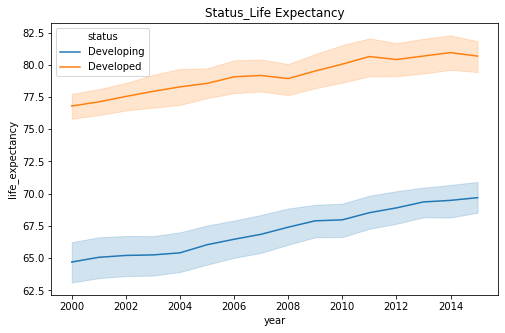

In [ ]:
# 그래프로 두 집단의 평균 기대 수명 차이 확인
developed_df = wins_df[['life_expectancy', 'year', 'status']]
plt.figure(figsize=(8, 5))
status_devel = sns.lineplot(data = developed_df, y='life_expectancy', x='year', hue='status')
status_devel.set(title = "Status_Life Expectancy");

##### ✅ status에 따른 두 집단 간의 평균 기대수명애 분명한 차이가 있음을 시각적으로도 확인할 수 있다.

In [ ]:
# schooling & life_expectancy 간 chi-square test: 두 변수 간의 연관성 확인
chi_res1 = chi2_contingency(pd.crosstab(wins_df['schooling'], wins_df['life_expectancy']))
print('schooling & life_expectancy_Chi2 Statistic: {}, p-value: {}'.format(chi_res1[0], chi_res1[1]))

# hdi & life_expectancy 간 chi-square test: 두 변수 간의 연관성 확인
chi_res2 = chi2_contingency(pd.crosstab(wins_df['hdi'], wins_df['life_expectancy']))
print('hdi & life_expectancy_Chi2 Statistic: {}, p-value: {}'.format(chi_res2[0], chi_res2[1]))

# hdi & schooling 간 chi-square test: 두 변수 간의 연관성 확인
chi_res3 = chi2_contingency(pd.crosstab(wins_df['hdi'], wins_df['schooling']))
print('hdi & schooling_Chi2 Statistic: {}, p-value: {}'.format(chi_res3[0], chi_res3[1]))

# gdp & life_expectancy 간 chi-square test: 두 변수 간의 연관성 확인
chi_resg = chi2_contingency(pd.crosstab(wins_df['gdp'], wins_df['life_expectancy']))
print('gdp & life_expectancy_Chi2 Statistic: {}, p-value: {}'.format(chi_resg[0], chi_resg[1]))

## 위 검정들의 p-value를 통해 교육수준/hdi 지수/status는 기대수명에 연관 있다고 할 수 있으나, gdp는 기대 수명과 연관 없다고 할 수 있을 것.


schooling & life_expectancy_Chi2 Statistic: 58836.824036414684, p-value: 5.433720742542671e-255
hdi & life_expectancy_Chi2 Statistic: 222400.6938098782, p-value: 0.0
hdi & schooling_Chi2 Statistic: 135386.5697474331, p-value: 0.0
gdp & life_expectancy_Chi2 Statistic: 620521.2510124523, p-value: 1.0


##### ✅ 교육수준, hdi 지수, GDP 모두 기대 수명과 연관된 변수임을 카이제곱검정 결과를 통해 확인

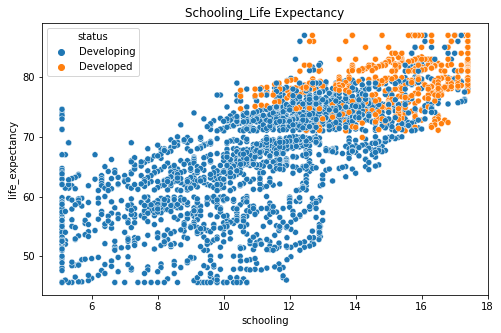

In [ ]:
# status를 기준으로 developed/developing으로 나누었을 때: schooling에 따른 기대수명 변화
stat_df = wins_df[['life_expectancy', 'year', 'status', 'schooling', 'hdi','gdp']]
plt.figure(figsize=(8, 5))
sch_le = sns.scatterplot(data = stat_df, y='life_expectancy', x='schooling', hue='status')
sch_le.set(title = "Schooling_Life Expectancy");

##### ✅ 교육수준에 따른 기대 수명의 추이를 통해 교육수준이 높을수록 기대 수명이 늘어나는 것을 볼 수 있음
- 대체로 선진국은 개발도상국에 비해 교육 수준이 높음

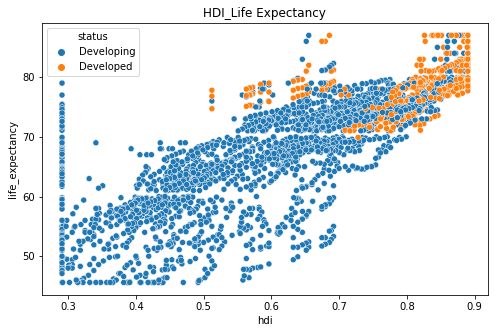

In [ ]:
# status를 기준으로 developed/developing으로 나누었을 때의: hdi에 따른 기대수명
plt.figure(figsize=(8, 5))
hdi_le = sns.scatterplot(data = stat_df, y='life_expectancy', x='hdi', hue='status')
hdi_le.set(title = "HDI_Life Expectancy");

##### ✅ 또한 HDI도 높을수록 기대 수명이 연장되는 경향이 있다는 것을 확인할 수 있다. 
- 더불어 선진국의 HDI 지수가 대체로 개발도상국보다 높다는 것을 확인할 수 있다.

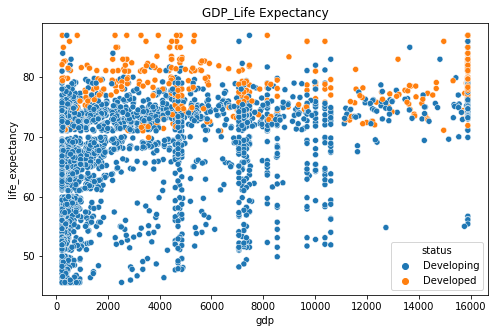

In [ ]:
# status를 기준으로 developed/developing으로 나누었을 때의: gdp에 따른 기대수명
plt.figure(figsize=(8, 5))
hdi_le = sns.scatterplot(data = stat_df, y='life_expectancy', x='gdp', hue='status')
hdi_le.set(title = "GDP_Life Expectancy");

##### ✅ 그래프에서 GDP가 증가할수록 기대수명이 낮은 케이스의 분포가 점차 사라지기 때문에 GDP가 증가할수록 기대 수명이 연장되는 경향이 있다는 것을 확인할 수 있다. 
- 마찬가지로 선진국의 GDP가 대체로 개발도상국보다 높다.

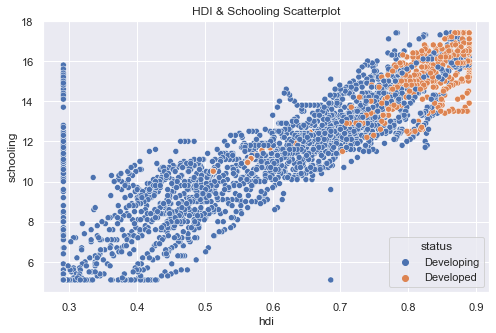

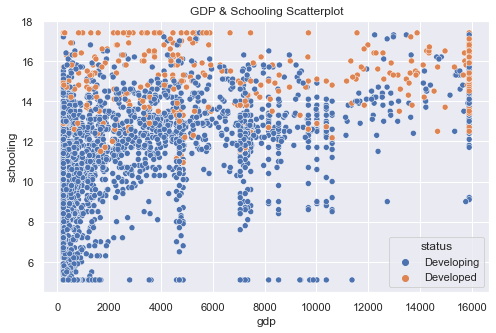

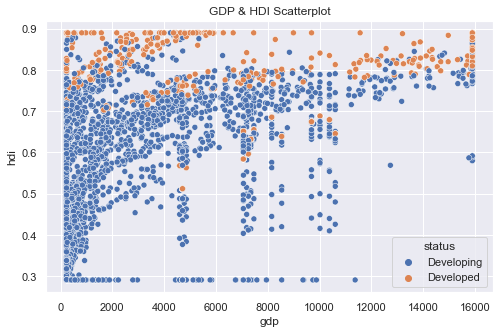

In [ ]:
# schooling과 hdi, gdp 간의 상관관계 파악
plt.figure(figsize=(8, 5))
hdi_le = sns.scatterplot(data = stat_df, y='schooling', x='hdi', hue='status')
hdi_le.set(title = "HDI & Schooling Scatterplot")      # 산포도도 둘 간의 비례 관계가 있음을 보여줌

plt.figure(figsize=(8, 5))
hdi_le = sns.scatterplot(data = stat_df, y='schooling', x='gdp', hue='status')
hdi_le.set(title = "GDP & Schooling Scatterplot") 

plt.figure(figsize=(8, 5))
hdi_le = sns.scatterplot(data = stat_df, y='hdi', x='gdp', hue='status')
hdi_le.set(title = "GDP & HDI Scatterplot") ;

##### ✅ 따라서 HDI와 교육수준 간의 상관관계를 scatterplot으로 그려보았을 때, 서로 비례관계에 있음을 알 수 있다. 
- 또한 선진국은 개발도상국에 비해 교육수준과 HDI 모두 더 높다는 것을 다시 한 번 확인할 수 있다.

#### 🔥 결론 : 통계적 검정과 데이터 시각화를 통해 국가가 선진화될수록 기대 수명이 증가할 수 있다는 가설 2가 성림될 수 있다.
-----

### 가설 3에 대한 검정

In [ ]:
# 3번 가설: 정부와 개인이 건강을 위해 소비하는 비중이 높을수록 기대 수명은 늘어날 것
# percentage_expenditure와 기대 수명 간 카이제곱검정 실시
chi_respex = chi2_contingency(pd.crosstab(wins_df['percentage_expenditure'], wins_df['life_expectancy']))
print('percentage_expenditure & life_expectancy_Chi2 Statistic: {}, p-value: {}'.format(chi_respex[0], chi_respex[1]))

# total_expenditure와 기대 수명 간 카이제곱검정 실시
chi_restex = chi2_contingency(pd.crosstab(wins_df['total_expenditure'], wins_df['life_expectancy']))
print('total_expenditure & life_expectancy_Chi2 Statistic: {}, p-value: {}'.format(chi_restex[0], chi_restex[1]))

# percentage_expenditure와 total_expenditure 간 카이제곱검정 실시
chi_resexs = chi2_contingency(pd.crosstab(wins_df['percentage_expenditure'], wins_df['total_expenditure']))
print('percentage_expenditure & total_expenditure_Chi2 Statistic: {}, p-value: {}'.format(chi_resexs[0], chi_resexs[1]))

# alcohol & life_expectancy 간 chi-square test
## 건강을 위해 소비하는 행위가 전혀 아니기 때문에 이또한 어떤 영향을 주는지 확인하기 위해 실시
chi_resal = chi2_contingency(pd.crosstab(wins_df['alcohol'], wins_df['life_expectancy']))
print('alcohol & life_expectancy_Chi2 Statistic: {}, p-value: {}'.format(chi_resal[0], chi_resal[1]))

# alcohol & percentage_expenditure 간 chi-square test
chi_resalexp = chi2_contingency(pd.crosstab(wins_df['alcohol'], wins_df['percentage_expenditure']))
print('alcohol & percentage_expenditure_Chi2 Statistic: {}, p-value: {}'.format(chi_resalexp[0], chi_resalexp[1]))

percentage_expenditure & life_expectancy_Chi2 Statistic: 681764.1003949224, p-value: 9.766660350236392e-116
total_expenditure & life_expectancy_Chi2 Statistic: 257024.45026718595, p-value: 0.7575309470505511
percentage_expenditure & total_expenditure_Chi2 Statistic: 1485089.7279672197, p-value: 7.381457227733676e-135
alcohol & life_expectancy_Chi2 Statistic: 346868.8930095977, p-value: 1.0
alcohol & percentage_expenditure_Chi2 Statistic: 2049505.6793536078, p-value: 1.2399960327569453e-70


##### ✅ 검정 결과를 통해 `GDP 대비 건강 관련 지출`만 기대 수명과 연관되어 있음을 확인
- 알코올 소비량과 정부 지출 대비 보건 관련 지출은 기대 수명과 연관없다고 볼 수 있다.

#### 🔥 결론 : 통계적 가설 검정과 데이터 시각화를 통해 `GDP 대비 건강 관련 지출`에 대해서만 가설 3이 성립함
- 알코올 소비량과 정부 지출 대비 보건 관련 지출에 대해서는 가설 3이 성립되지 않고 있다.
----------

## 기대수명 예측 모델링

### 5-1. Feature Engineering 및 데이터 전처리
    1. 5세 미만 아동 사망률 중 hiv/aids로 사망할 확률에 대한 feature 추가하기
    2. 기대수명과 카이제곱검정을 했을 때 p-value=1인, 즉 기대수명과 연관성이 없는 세 가지 변수인 gdp, population, alcohol 제거하기
    3. categorical 변수 처리하기

In [20]:
# 1. 5세 미만 아동 사망률 중 hiv/aids로 사망할 확률에 대한 feature 추가

# 해당 함수 생성 
def percent_hivaids(df):
    df['percent_hiv'] = df['hiv'] / (df['under_five_mortality']*1000)
    return df

wins_df2 = percent_hivaids(wins_df)     # hiv/aids로 사망할 확률에 대한 feature 추가
wins_df2.head(3)

,country,year,status,bmi,life_expectancy,adult_mortality,infant_mortality,alcohol,percentage_expenditure,hepatitis_b,...,total_expenditure,diphtheria,hiv,gdp,population,thin_1019,thin_59,hdi,schooling,percent_hiv
0,Afghanistan,2015,Developing,19.1,65.0,0.263,0.055,0.010000,71.279624,65.0,...,8.16,65.0,0.1,584.25921,28656282.0,14.6,15.0,0.479,10.1,0.001515
16,Albania,2015,Developing,58.0,77.8,0.074,0.000,4.600000,364.975229,99.0,...,6.00,99.0,0.1,3954.22783,28873.0,1.2,1.3,0.762,14.2,NaN
32,Algeria,2015,Developing,59.5,75.6,0.019,0.021,5.288333,0.000000,95.0,...,7.08,95.0,0.1,4132.76292,28656282.0,6.0,5.8,0.743,14.4,0.004167


In [21]:
# 결측치 확인
print('percent_hiv 결측치 수: ', wins_df2['percent_hiv'].isna().sum())
print('-'*20)

# 결측치 처리하기 위해 분자/분모인 변수에 value==0인 경우 있는지 확인
print('hiv \n', wins_df2['hiv'].value_counts())
print('-'*20)
print('\nunder_five_mortality: \n', wins_df2['under_five_mortality'].value_counts())

percent_hiv 결측치 수:  785
--------------------
hiv 
 0.1    1781
1.7     563
0.2     124
0.3     115
0.4      69
0.5      42
0.6      35
0.8      32
0.9      32
0.7      29
1.6      21
1.5      21
1.2      18
1.1      15
1.4      15
1.3      14
1.0      12
Name: hiv, dtype: int64
--------------------

under_five_mortality: 
 0.000    785
0.066    412
0.001    361
0.002    163
0.004    161
        ... 
0.051      4
0.060      4
0.059      3
0.057      2
0.053      2
Name: under_five_mortality, Length: 67, dtype: int64


- percent_hiv/aids의 결측치는 under-five_mortality의 value==0이어서 생겨나므로 결측치를 0으로 처리한다.

In [22]:
# 결측치 0으로 처리하기
wins_df2['percent_hiv'].fillna(0, inplace=True)
print('percent_hiv 결측치 수: ', wins_df2['percent_hiv'].isna().sum())

percent_hiv 결측치 수:  0


In [23]:
# 2. 기대수명과 연관성이 없는 population 제거
wins_df2.drop(columns =['population'], axis=1, inplace=True)
wins_df2.head(3)

,country,year,status,bmi,life_expectancy,adult_mortality,infant_mortality,alcohol,percentage_expenditure,hepatitis_b,...,polio,total_expenditure,diphtheria,hiv,gdp,thin_1019,thin_59,hdi,schooling,percent_hiv
0,Afghanistan,2015,Developing,19.1,65.0,0.263,0.055,0.010000,71.279624,65.0,...,52.0,8.16,65.0,0.1,584.25921,14.6,15.0,0.479,10.1,0.001515
16,Albania,2015,Developing,58.0,77.8,0.074,0.000,4.600000,364.975229,99.0,...,99.0,6.00,99.0,0.1,3954.22783,1.2,1.3,0.762,14.2,0.000000
32,Algeria,2015,Developing,59.5,75.6,0.019,0.021,5.288333,0.000000,95.0,...,95.0,7.08,95.0,0.1,4132.76292,6.0,5.8,0.743,14.4,0.004167


In [24]:
# 3. categorical 변수(country, status) 처리하기
## country는 제거
wins_df2.drop(columns =['country'], axis=1, inplace=True)

## status는 더미화해 수치화함
wins_df2 = pd.concat([wins_df2, pd.get_dummies(wins_df2['status'],drop_first=True)],axis=1)
wins_df2.drop(columns =['status'], axis=1, inplace=True)    ## 기존의 status는 제거하기

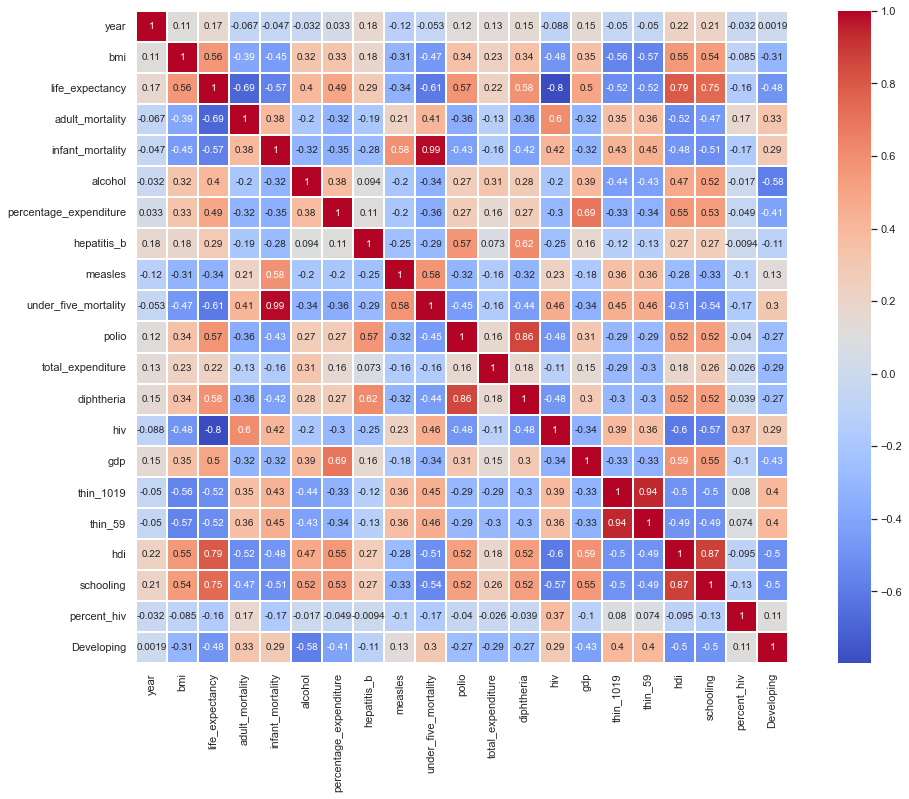

In [27]:
# winds_df2에 대한 heat map: 연속형 변수들 간의 상관관계 파악
sns.set(rc = {'figure.figsize':(18,12)})
sns.heatmap(wins_df2[wins_df2.columns].astype(float).corr(), linewidths = 0.1, vmax = 1.0, cmap='coolwarm', square = True, linecolor = "white", annot = True, annot_kws = {"size" : 10});

- heatmap에서 유아 사망률&5세 미만 아동 사망률, schooling&hdi, thin_10-19&thin_5-9 간의 상관관계가 높다는 것을 확인할 수 있다.

- 따라서 이 변수들 중에서 기대수명과의 상관계수가 더 높은 것만 남겨두기로 한다.

In [25]:
# 컬럼 정리하기
wins_df2.drop(columns =['infant_mortality', 'schooling', 'thin_59'], axis=1, inplace=True)
wins_df2.head(3)

,year,bmi,life_expectancy,adult_mortality,alcohol,percentage_expenditure,hepatitis_b,measles,under_five_mortality,polio,total_expenditure,diphtheria,hiv,gdp,thin_1019,hdi,percent_hiv,Developing
0,2015,19.1,65.0,0.263,0.010000,71.279624,65.0,0.741,0.066,52.0,8.16,65.0,0.1,584.25921,14.6,0.479,0.001515,1
16,2015,58.0,77.8,0.074,4.600000,364.975229,99.0,0.000,0.000,99.0,6.00,99.0,0.1,3954.22783,1.2,0.762,0.000000,1
32,2015,59.5,75.6,0.019,5.288333,0.000000,95.0,0.063,0.024,95.0,7.08,95.0,0.1,4132.76292,6.0,0.743,0.004167,1


### 5-2. 모델 학습
아래 총 4가지 머신러닝 모델로 기대수명을 예측해볼 것이다.

1. Linear Regression
2. Ridge Regression
3. Randomforest Regressor
4. XGBRegressor

In [26]:
# 독립/종속 변수 설정
target = 'life_expectancy'
feature = wins_df2.drop(columns=[target]).columns

# test/train/val으로 데이터셋 구분하기
train = wins_df2[wins_df2['year'] != 2015]
val = train[train['year'] == 2014]
test = wins_df2[wins_df2['year'] == 2015]
train.shape, val.shape, test.shape

((2755, 18), (183, 18), (183, 18))

In [27]:
# 훈련세트-독립/종속변수 지정 + 테스트세트-독립/종속변수 지정
X_train = train[feature]
y_train = train[target]
X_test = test[feature]
y_test = test[target]
X_val = val[feature]
y_val = val[target]

In [29]:
# baseline: target(기대 수명)의 평균 값
y = wins_df2[target]
baseline = [y.mean()] *len(y)

# baseline의 r2, mae
print('R2 score:', r2_score(y, baseline))
print('MAE: ', mean_absolute_error(y, baseline))
print('MSE: ', mean_squared_error(y, baseline))
print('RMSE: ', mean_squared_error(y, baseline)**0.5)

R2 score: 0.0
MAE:  7.741863297777127
MSE:  89.0963630582181
RMSE:  9.439086982236052


In [30]:
# 1. linear regression
model = LinearRegression()
model.fit(X_train, y_train)

## linear regression 평가지표
y_pred = model.predict(X_val)

mae = mean_absolute_error(y_val, y_pred)
mse = mean_squared_error(y_val, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_val, y_pred)

print('Linear Regression validation', 'MAE: {}'.format(mae), 'MSE: {}'.format(mse), 'RMSE: {}'.format(rmse), 'r2 score: {}'.format(r2))
print('Linear Regression validation_r2 score: ', model.score(X_val, y_val)) 

Linear Regression validation MAE: 2.39388772339964 MSE: 10.26648180124221 RMSE: 3.204135109704678 r2 score: 0.8559515731374612
Linear Regression validation_r2 score:  0.8559515731374612


In [31]:
# 2. Ridge Regression 
alpha = np.arange(0.1, 50, 0.1)
model_ridge = RidgeCV(alphas=alpha, cv=3)  
model_ridge.fit(X_train, y_train)
y_pred_ridge = model_ridge.predict(X_val)

print("alpha: ", model_ridge.alpha_)
print("best score: ", model_ridge.best_score_)

# 평가지표 출력
mae_r = mean_absolute_error(y_val, y_pred_ridge)
mse_r = mean_squared_error(y_val, y_pred_ridge)
rmse_r = mse_r ** 0.5
r2_r = r2_score(y_test, y_pred_ridge)
print('Ridge Regression validation', 'MAE: {}'.format(mae_r), 'MSE: {}'.format(mse_r), 'RMSE: {}'.format(rmse_r), 'r2_score: {}'.format(r2_r))
print('Ridge Regression validation_r2 score: ', model.score(X_val, y_val)) 

alpha:  0.1
best score:  0.8460222195151464
Ridge Regression validation MAE: 2.3856278304360305 MSE: 10.242250542316624 RMSE: 3.20035162791788 r2_score: 0.8648268328849542
Ridge Regression validation_r2 score:  0.8559515731374612


- **이미 Ridge에서 alpha=0일 때 best이기 때문에 Lasso Regression 모델로 학습을 진행하지 않을 것!**

In [32]:
# Random Forest 모델 구축
model_rf = RandomForestRegressor()
model_rf.fit(X_train, y_train)
y_pred_rf = model_rf.predict(X_val)

# 평가지표 출력
mae_rf = mean_absolute_error(y_val, y_pred_rf)
mse_rf = mean_squared_error(y_val, y_pred_rf)
rmse_rf = mse_rf ** 0.5
print('Random Forest Regressor validation', 'MAE: {}'.format(mae_rf), 'MSE: {}'.format(mse_rf), 'RMSE: {}'.format(rmse_rf))

print('Random Forest Regressor validation_r2 score: ', model_rf.score(X_val, y_val)) 

Random Forest Regressor validation MAE: 0.4664479082683867 MSE: 0.5277087785585574 RMSE: 0.7264356671850284
Random Forest Regressor validation_r2 score:  0.9925957479042417


In [37]:
# XGBRegressor 모델 학습
model_xgb = xgb.XGBRegressor()      # 하이퍼파라미터 설명 레퍼런스: http://okminseok.blogspot.com/2017/09/ml-xgboost.html
model_xgb.fit(X_train,y_train)
y_pred_xgb = model_xgb.predict(X_val)

# train/validation 평가지표
print('XGBRegressor train score: ', model_xgb.score(X_train, y_train))

mae_xgb = mean_absolute_error(y_val, y_pred_xgb)
mse_xgb = mean_squared_error(y_val, y_pred_xgb)
rmse_xgb = mse_xgb ** 0.5
print('XGBRegressor validation', 'MAE: {}'.format(mae_xgb), 'MSE: {}'.format(mse_xgb), 'RMSE: {}'.format(rmse_xgb))

print('XGBRegressor validation_r2 score: ', model_xgb.score(X_val, y_val)) 

XGBRegressor train score:  0.9989341956362303
XGBRegressor validation MAE: 0.16723350566593012 MSE: 0.05642250608947678 RMSE: 0.23753422088085913
XGBRegressor validation_r2 score:  0.9992083390007229


#### 👇🏼 XGBRegressor의 성능이 가장 뛰어났으므로 이 모델에 대해 test 데이터에 대한 성능을 도출하여 아래와 같이 나타냄

In [38]:
# test 데이터 성능 도출: XGB
y_pred_test = model_xgb.predict(X_test)

mae_test = mean_absolute_error(y_test, y_pred_test)
mse_test = mean_squared_error(y_test, y_pred_test)
rmse_test = mse_test ** 0.5
print('XGBRegressor', 'Test MAE: {}'.format(mae_test), 'Test MSE: {}'.format(mse_test), 'Test RMSE: {}'.format(rmse_test))

print('XGBRegressor Test_r2 score: ', model_xgb.score(X_test, y_test)) 


XGBRegressor Test MAE: 1.5988149048852143 Test MSE: 4.078265291042675 Test RMSE: 2.0194715375668646
XGBRegressor Test_r2 score:  0.9376987037089975
